**Training - CLASSIFICATION:**  This script has the code for training CNNs in the classification task.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/Shareddrives/Projeto DACO/scripts code

/content/drive/Shareddrives/Projeto DACO/scripts code


In [ ]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.4 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from torchvision.ops.focal_loss import sigmoid_focal_loss
import albumentations as A
from albumentations.pytorch import ToTensorV2
from time import time
from tqdm import tqdm
from torchinfo import summary
import datetime
import importlib
import os
import argparse
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torchvision.models as models

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import class_weight

# Dataloader
import import_ipynb
from dataloader import small_dataset
from sklearn import preprocessing


from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

importing Jupyter notebook from dataloader.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Detection's Label Map
Class 0 -  ['hemorrhage']
Class 1 -  ['no hemorrhage']

Classification's Label Map
Class 0 -  [' epidural']
Class 1 -  [' intraparenchymal']
Class 2 -  [' intraventricular']
Class 3 -  [' subarachnoid']
Class 4 -  [' subdural']
Class 5 -  ['no hemorrhage']
[10.925       0.99036827  1.52663755  0.90805195  0.46675567]
Using cuda


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
###################### TRAINING MODE #####################

dataset_fold = 'windowing' # ['original', 'windowing']
model_selected = 'VGG' # ['VGG', 'ResNeXt']

print(f'Training Mode using {dataset_fold} images')


################## PARAMETERS ##################


img_size = 224
BATCH_SIZE = 16
LEARNING_RATE = 0.000005 
NUM_WORKERS = 2
EPOCHS = 180


Training Mode using windowing images


In [ ]:
def epoch_iterations (dataloader, model, loss_fc, device, name, opt=None, is_training=True):
  if (is_training):
      assert opt is not None, "When training, please provide an optimizer."
      model.train() 
  else:
    model.eval()
  
  model.to(device) 
  
  tic = time()
  total_time = 0
  
  true_label = []
  final_pred = []
  avg_loss = 0
  
  
  with torch.set_grad_enabled(is_training):
    for img, notlabel, label in tqdm(dataloader):
        img = img.to(device)
        
        for i in label:
          true_label.append(int(i.numpy()))
        
        label = label.type(torch.LongTensor)
        label = label.to(device)

        label_pred = model(img)

        loss = loss_fc(label_pred, label)

        if (is_training):
          opt.zero_grad()
          loss.backward()
          opt.step()

        avg_loss += float(loss.item()) / len(dataloader)

        y_pred = torch.softmax(label_pred, dim=1).argmax(dim=1)
        
        for j in y_pred.cpu():
          final_pred.append(int(j.detach().numpy()))


  toc = time()
  total_time += toc-tic

  print(f'{name} - Time: {toc-tic:.1f}s - Loss: {avg_loss}')

  return avg_loss, true_label, final_pred

  

In [ ]:
import seaborn as sns

def evaluation_metrics (true_label, final_pred):
  # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(true_label, final_pred, labels = [0,1,2,3,4])
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show(block=False)


In [ ]:
def loss_plot (epochs, train_loss, val_loss):
  fig = plt.figure(figsize=(10,5))
  plt.title('Loss')
  plt.plot(epochs, train_loss, label='train')
  plt.plot(epochs, val_loss, label='val')
  plt.legend(loc='best')

  plt.tight_layout()
  plt.legend(loc='best')
  plt.show()


In [ ]:
def loss_plot2 (epochs, train_loss):
  fig = plt.figure(figsize=(10,5))
  plt.title('Loss')
  plt.plot(epochs, train_loss, label='train')
  plt.legend(loc='best')

  plt.tight_layout()
  plt.legend(loc='best')
  plt.show()

Loading dataset

Detection's Label Map
Class 0 -  ['hemorrhage']
Class 1 -  ['no hemorrhage']

Classification's Label Map
Class 0 -  [' epidural']
Class 1 -  [' intraparenchymal']
Class 2 -  [' intraventricular']
Class 3 -  [' subarachnoid']
Class 4 -  [' subdural']
Class 5 -  ['no hemorrhage']

Loaded 


Training
* Epoch 1 / 180


100%|██████████| 158/158 [05:26<00:00,  2.07s/it]


TRAIN - Time: 326.5s - Loss: 1.6203715763514555


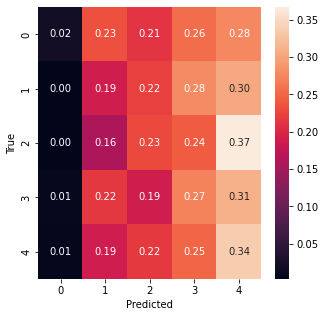

100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


VALIDATION - Time: 44.5s - Loss: 1.6850385325295585


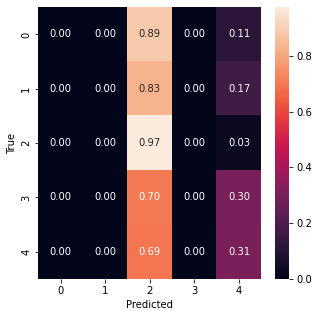

* Epoch 2 / 180


100%|██████████| 158/158 [00:59<00:00,  2.64it/s]


TRAIN - Time: 59.9s - Loss: 1.6133182531670696


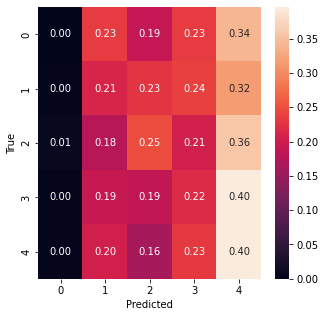

100%|██████████| 28/28 [00:04<00:00,  5.77it/s]


VALIDATION - Time: 4.9s - Loss: 1.6138051322528293


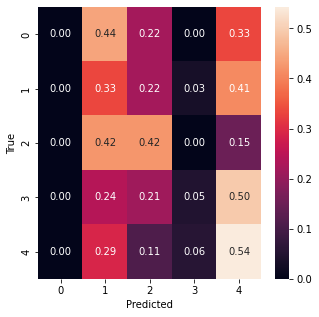

* Epoch 3 / 180


100%|██████████| 158/158 [00:52<00:00,  3.00it/s]


TRAIN - Time: 52.6s - Loss: 1.6011376758165


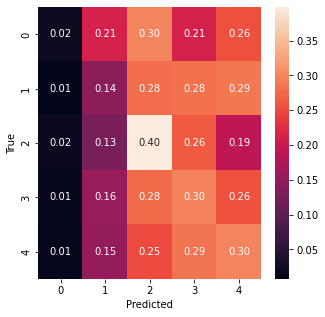

100%|██████████| 28/28 [00:04<00:00,  5.68it/s]


VALIDATION - Time: 4.9s - Loss: 1.6473420688084195


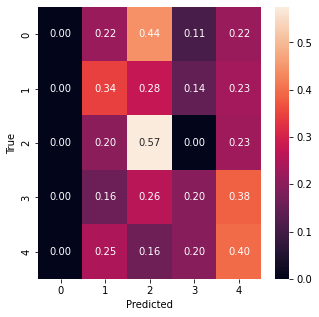

* Epoch 4 / 180


100%|██████████| 158/158 [00:52<00:00,  2.98it/s]


TRAIN - Time: 53.0s - Loss: 1.5984433429150637


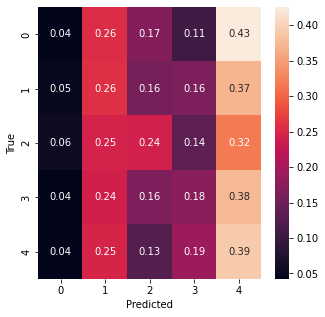

100%|██████████| 28/28 [00:04<00:00,  5.67it/s]


VALIDATION - Time: 4.9s - Loss: 1.5986989821706497


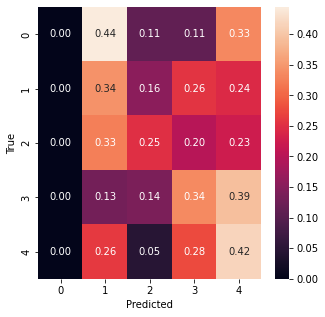

* Epoch 5 / 180


100%|██████████| 158/158 [00:52<00:00,  2.99it/s]


TRAIN - Time: 52.8s - Loss: 1.6180052742173399


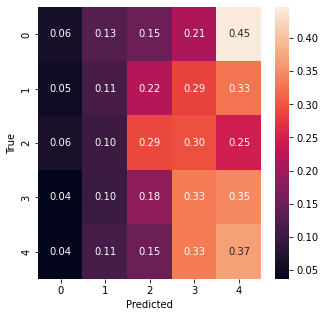

100%|██████████| 28/28 [00:04<00:00,  5.61it/s]


VALIDATION - Time: 5.0s - Loss: 1.57274267077446


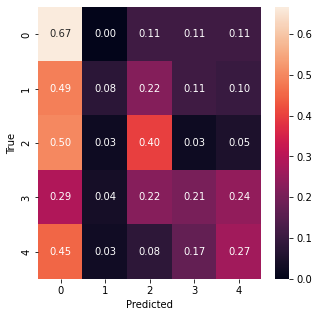

* Epoch 6 / 180


100%|██████████| 158/158 [00:55<00:00,  2.85it/s]


TRAIN - Time: 55.5s - Loss: 1.5866493612905102


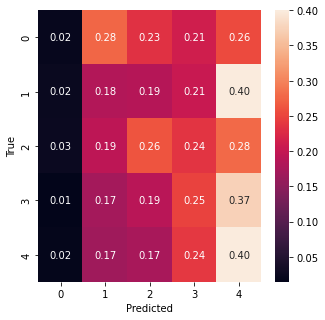

100%|██████████| 28/28 [00:04<00:00,  5.69it/s]


VALIDATION - Time: 4.9s - Loss: 1.6662443450519018


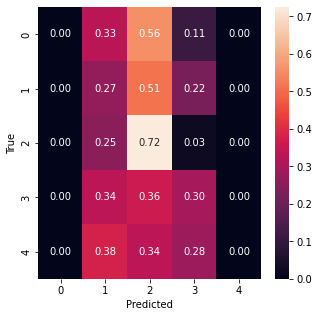

* Epoch 7 / 180


100%|██████████| 158/158 [00:52<00:00,  3.03it/s]


TRAIN - Time: 52.2s - Loss: 1.5890406619144388


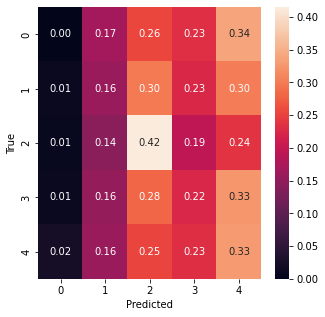

100%|██████████| 28/28 [00:04<00:00,  5.61it/s]


VALIDATION - Time: 5.0s - Loss: 1.6812657330717355


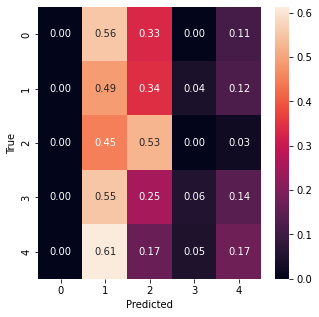

* Epoch 8 / 180


100%|██████████| 158/158 [00:52<00:00,  3.02it/s]


TRAIN - Time: 52.3s - Loss: 1.6030174742771097


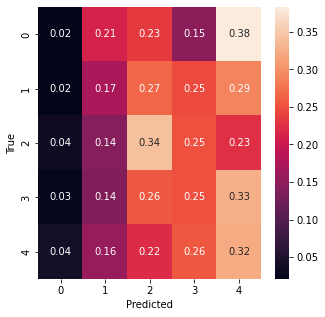

100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


VALIDATION - Time: 5.1s - Loss: 1.5676108258111134


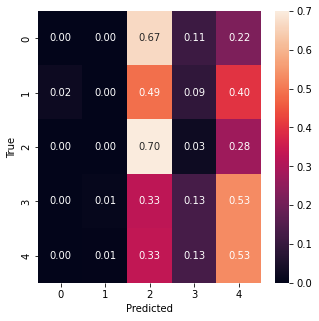

* Epoch 9 / 180


100%|██████████| 158/158 [00:53<00:00,  2.98it/s]


TRAIN - Time: 53.1s - Loss: 1.6029949059969255


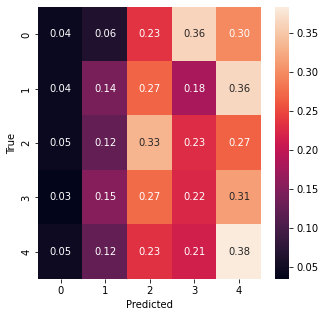

100%|██████████| 28/28 [00:04<00:00,  5.62it/s]


VALIDATION - Time: 5.0s - Loss: 1.610428631305695


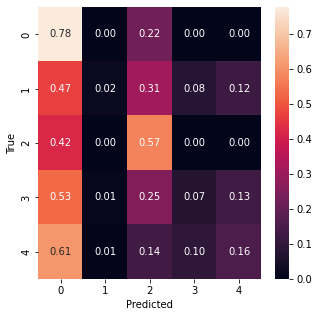

* Epoch 10 / 180


100%|██████████| 158/158 [00:52<00:00,  3.02it/s]


TRAIN - Time: 52.3s - Loss: 1.6041970373708987


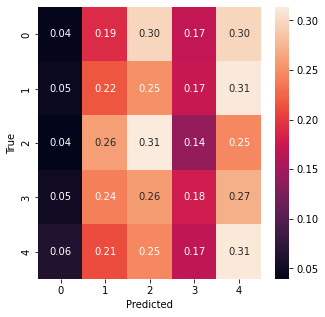

100%|██████████| 28/28 [00:04<00:00,  5.63it/s]


VALIDATION - Time: 5.0s - Loss: 1.551238634756633


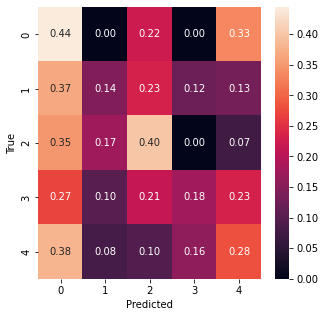

* Epoch 11 / 180


100%|██████████| 158/158 [00:55<00:00,  2.85it/s]


TRAIN - Time: 55.5s - Loss: 1.5898937884765336


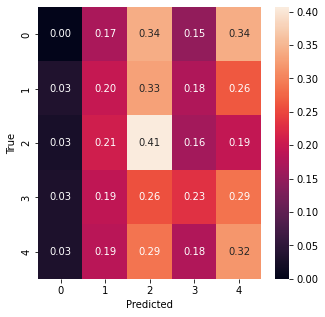

100%|██████████| 28/28 [00:05<00:00,  5.56it/s]


VALIDATION - Time: 5.0s - Loss: 1.6437406412192754


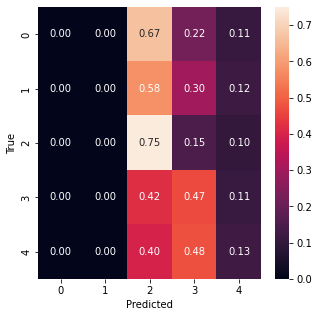

* Epoch 12 / 180


100%|██████████| 158/158 [00:51<00:00,  3.04it/s]


TRAIN - Time: 52.0s - Loss: 1.5730670192573646


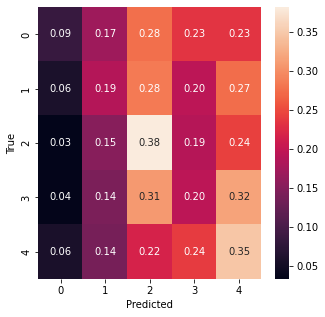

100%|██████████| 28/28 [00:05<00:00,  5.59it/s]


VALIDATION - Time: 5.0s - Loss: 1.647578899349485


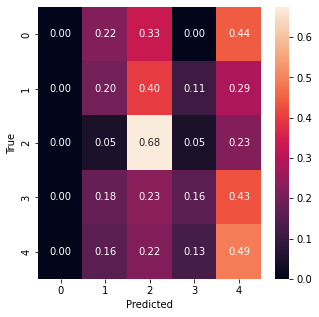

* Epoch 13 / 180


100%|██████████| 158/158 [00:52<00:00,  3.01it/s]


TRAIN - Time: 52.5s - Loss: 1.5888399398779574


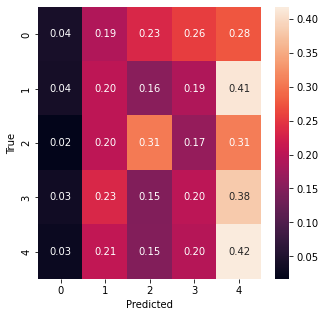

100%|██████████| 28/28 [00:04<00:00,  5.65it/s]


VALIDATION - Time: 5.0s - Loss: 1.5972564092704231


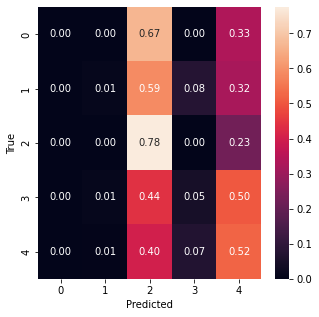

* Epoch 14 / 180


100%|██████████| 158/158 [00:52<00:00,  3.02it/s]


TRAIN - Time: 52.4s - Loss: 1.573169813125948


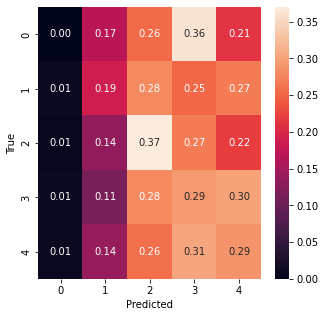

100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


VALIDATION - Time: 5.1s - Loss: 1.5696869449956075


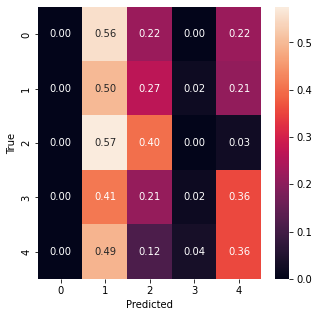

* Epoch 15 / 180


100%|██████████| 158/158 [00:52<00:00,  3.04it/s]


TRAIN - Time: 52.1s - Loss: 1.570225628870952


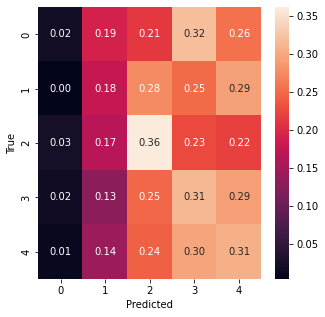

100%|██████████| 28/28 [00:05<00:00,  5.37it/s]


VALIDATION - Time: 5.2s - Loss: 1.5643882325717382


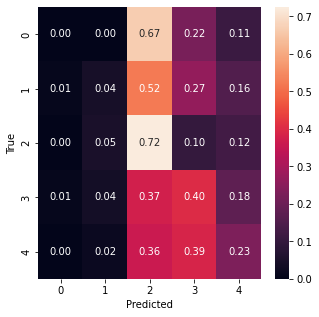

* Epoch 16 / 180


100%|██████████| 158/158 [00:54<00:00,  2.90it/s]


TRAIN - Time: 54.5s - Loss: 1.5790182140809064


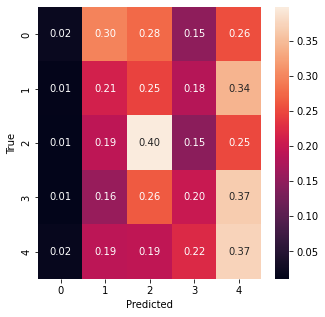

100%|██████████| 28/28 [00:04<00:00,  5.64it/s]


VALIDATION - Time: 5.0s - Loss: 1.5772816538810728


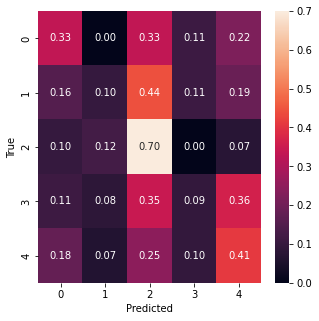

* Epoch 17 / 180


100%|██████████| 158/158 [00:52<00:00,  3.02it/s]


TRAIN - Time: 52.3s - Loss: 1.5806556585468812


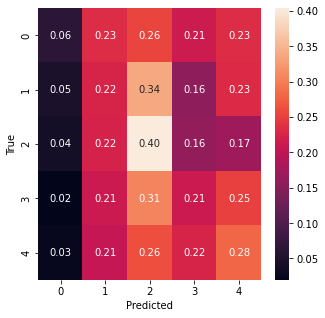

100%|██████████| 28/28 [00:05<00:00,  5.45it/s]


VALIDATION - Time: 5.1s - Loss: 1.5855335380349842


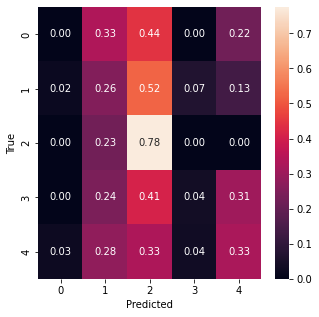

* Epoch 18 / 180


100%|██████████| 158/158 [00:52<00:00,  2.99it/s]


TRAIN - Time: 52.9s - Loss: 1.561142651340628


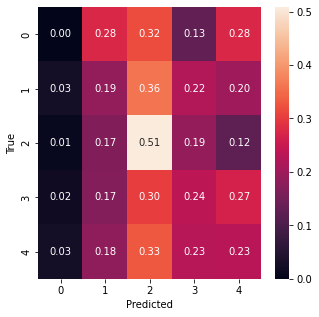

100%|██████████| 28/28 [00:05<00:00,  5.45it/s]


VALIDATION - Time: 5.1s - Loss: 1.552765876054764


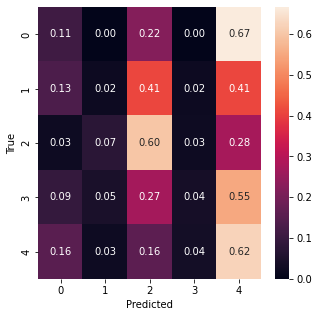

* Epoch 19 / 180


100%|██████████| 158/158 [00:53<00:00,  2.98it/s]


TRAIN - Time: 53.1s - Loss: 1.573651863049857


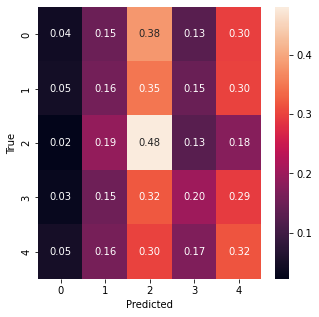

100%|██████████| 28/28 [00:05<00:00,  5.57it/s]


VALIDATION - Time: 5.0s - Loss: 1.6115050145557952


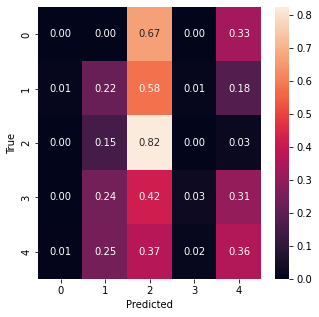

* Epoch 20 / 180


100%|██████████| 158/158 [00:52<00:00,  3.01it/s]


TRAIN - Time: 52.5s - Loss: 1.5731568313852142


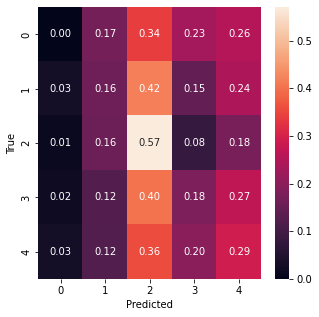

100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


VALIDATION - Time: 5.1s - Loss: 1.5677021401269096


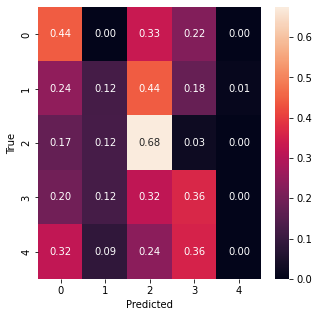

* Epoch 21 / 180


100%|██████████| 158/158 [00:55<00:00,  2.84it/s]


TRAIN - Time: 55.7s - Loss: 1.5649502850786041


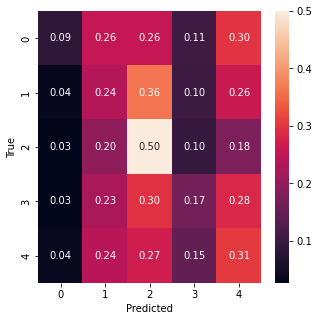

100%|██████████| 28/28 [00:05<00:00,  5.56it/s]


VALIDATION - Time: 5.0s - Loss: 1.6311881542205813


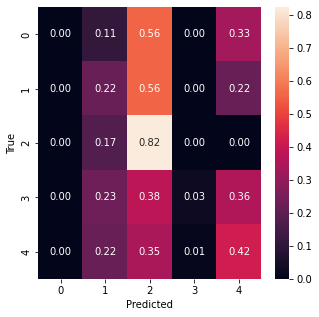

* Epoch 22 / 180


100%|██████████| 158/158 [00:52<00:00,  3.03it/s]


TRAIN - Time: 52.2s - Loss: 1.5551433631136453


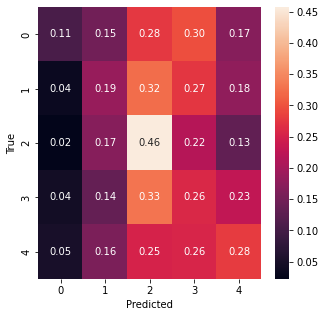

100%|██████████| 28/28 [00:05<00:00,  5.32it/s]


VALIDATION - Time: 5.3s - Loss: 1.5023749087538036


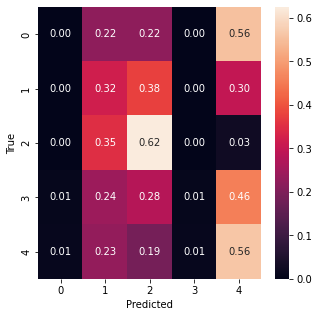

* Epoch 23 / 180


100%|██████████| 158/158 [00:52<00:00,  2.98it/s]


TRAIN - Time: 53.0s - Loss: 1.5568461576594577


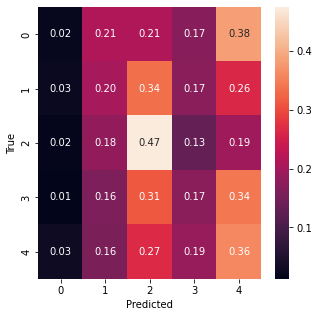

100%|██████████| 28/28 [00:04<00:00,  5.65it/s]


VALIDATION - Time: 5.0s - Loss: 1.5060663095542361


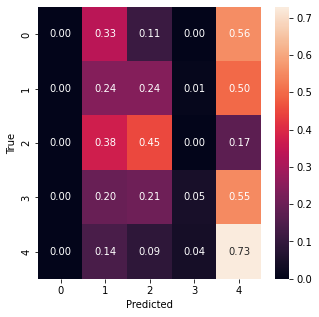

* Epoch 24 / 180


100%|██████████| 158/158 [00:52<00:00,  2.99it/s]


TRAIN - Time: 52.9s - Loss: 1.5542120910898038


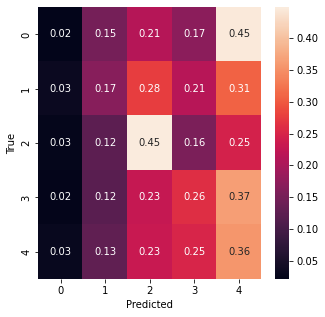

100%|██████████| 28/28 [00:05<00:00,  5.42it/s]


VALIDATION - Time: 5.2s - Loss: 1.7441814754690443


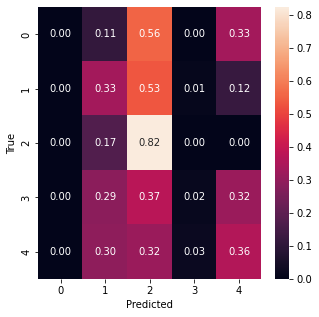

* Epoch 25 / 180


100%|██████████| 158/158 [00:52<00:00,  3.01it/s]


TRAIN - Time: 52.5s - Loss: 1.565771253803108


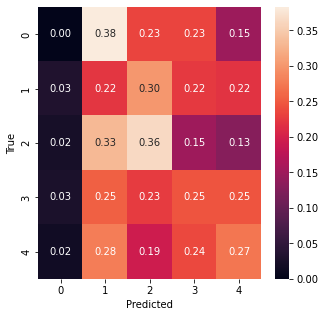

100%|██████████| 28/28 [00:05<00:00,  5.56it/s]


VALIDATION - Time: 5.0s - Loss: 1.5322303261075705


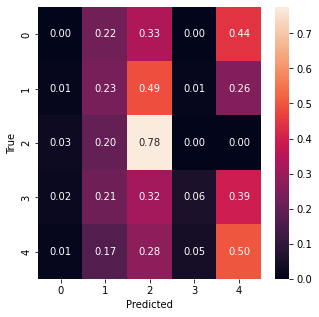

* Epoch 26 / 180


100%|██████████| 158/158 [00:59<00:00,  2.67it/s]


TRAIN - Time: 59.3s - Loss: 1.542417688460289


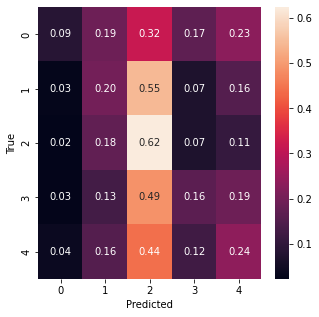

100%|██████████| 28/28 [00:05<00:00,  5.03it/s]


VALIDATION - Time: 5.6s - Loss: 1.4771600791386195


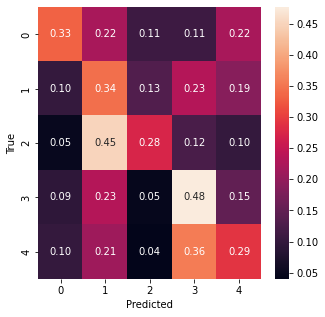

* Epoch 27 / 180


100%|██████████| 158/158 [00:56<00:00,  2.78it/s]


TRAIN - Time: 56.9s - Loss: 1.5349707452556753


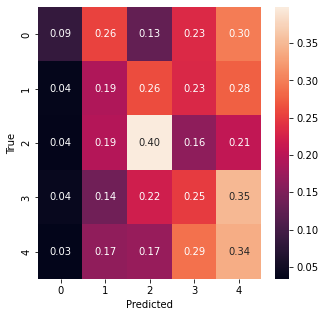

100%|██████████| 28/28 [00:05<00:00,  5.21it/s]


VALIDATION - Time: 5.4s - Loss: 1.4997190151895794


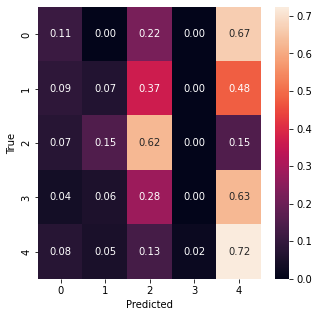

* Epoch 28 / 180


100%|██████████| 158/158 [00:55<00:00,  2.84it/s]


TRAIN - Time: 55.7s - Loss: 1.5225435691543765


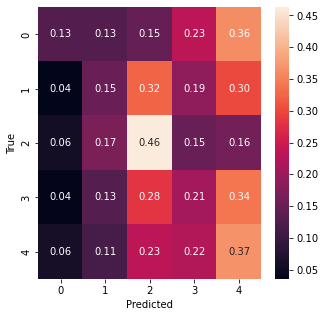

100%|██████████| 28/28 [00:05<00:00,  5.06it/s]


VALIDATION - Time: 5.5s - Loss: 1.5574670348848614


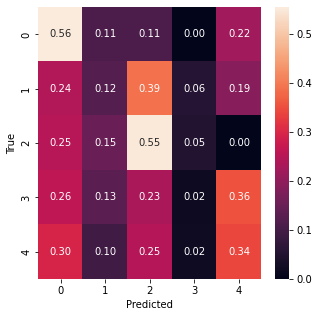

* Epoch 29 / 180


100%|██████████| 158/158 [00:55<00:00,  2.86it/s]


TRAIN - Time: 55.2s - Loss: 1.5638620476179472


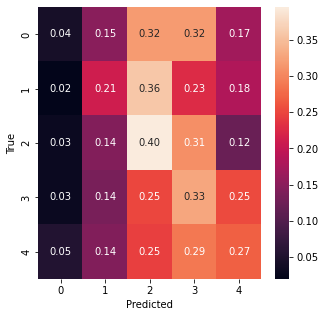

100%|██████████| 28/28 [00:05<00:00,  4.94it/s]


VALIDATION - Time: 5.7s - Loss: 1.5122590277876171


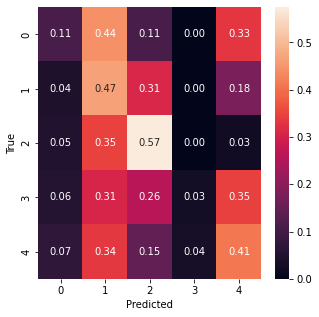

* Epoch 30 / 180


100%|██████████| 158/158 [00:55<00:00,  2.85it/s]


TRAIN - Time: 55.4s - Loss: 1.5499674858926216


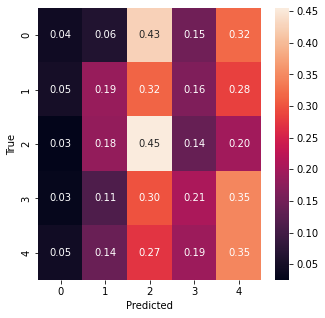

100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


VALIDATION - Time: 5.4s - Loss: 1.6293400994368958


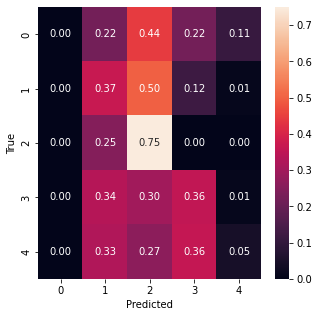

* Epoch 31 / 180


100%|██████████| 158/158 [00:56<00:00,  2.78it/s]


TRAIN - Time: 56.9s - Loss: 1.5308662615244901


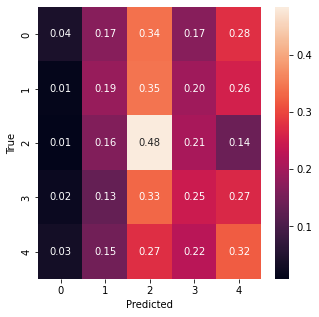

100%|██████████| 28/28 [00:05<00:00,  5.41it/s]


VALIDATION - Time: 5.2s - Loss: 1.582476718085153


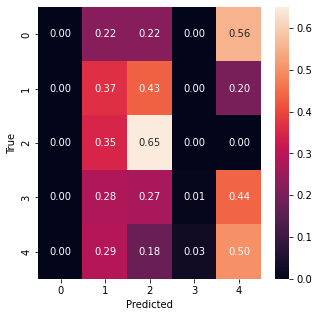

* Epoch 32 / 180


100%|██████████| 158/158 [00:54<00:00,  2.89it/s]


TRAIN - Time: 54.7s - Loss: 1.5392387200005448


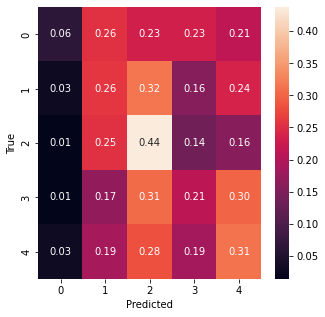

100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


VALIDATION - Time: 5.4s - Loss: 1.5745128563472202


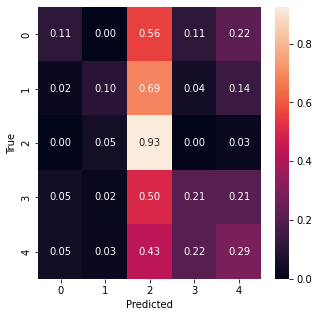

* Epoch 33 / 180


100%|██████████| 158/158 [00:54<00:00,  2.90it/s]


TRAIN - Time: 54.5s - Loss: 1.5560646751258944


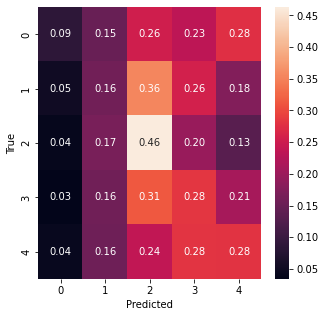

100%|██████████| 28/28 [00:05<00:00,  5.23it/s]


VALIDATION - Time: 5.4s - Loss: 1.4835694559982842


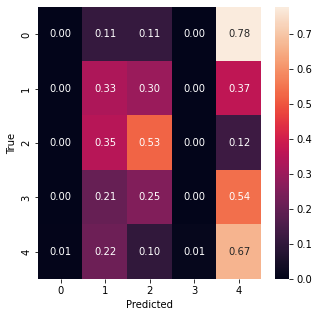

* Epoch 34 / 180


100%|██████████| 158/158 [00:55<00:00,  2.83it/s]


TRAIN - Time: 55.8s - Loss: 1.5375573363485213


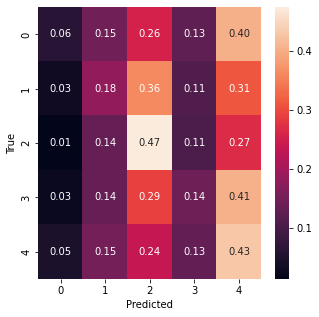

100%|██████████| 28/28 [00:05<00:00,  4.93it/s]


VALIDATION - Time: 5.7s - Loss: 1.4961658631052288


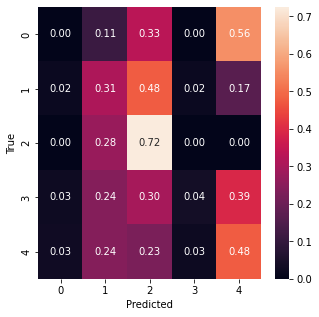

* Epoch 35 / 180


100%|██████████| 158/158 [01:00<00:00,  2.63it/s]


TRAIN - Time: 60.1s - Loss: 1.5331742944596687


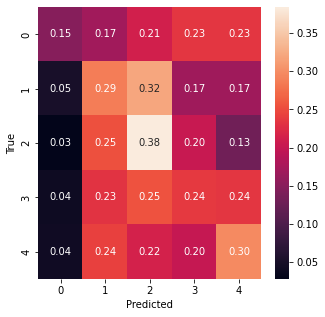

100%|██████████| 28/28 [00:05<00:00,  4.99it/s]


VALIDATION - Time: 5.6s - Loss: 1.489312631743295


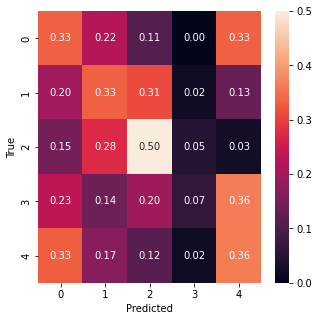

* Epoch 36 / 180


100%|██████████| 158/158 [00:56<00:00,  2.80it/s]


TRAIN - Time: 56.5s - Loss: 1.5373515728153773


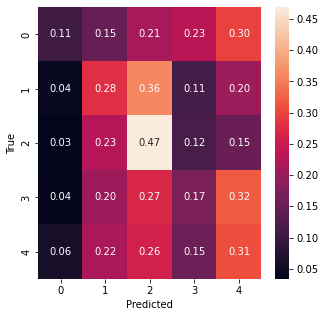

100%|██████████| 28/28 [00:05<00:00,  4.80it/s]


VALIDATION - Time: 5.9s - Loss: 1.5289114841393063


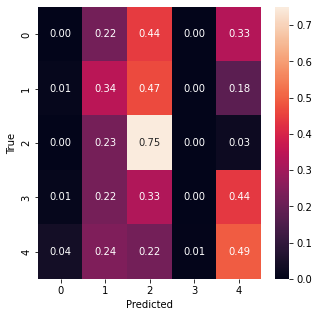

* Epoch 37 / 180


100%|██████████| 158/158 [00:56<00:00,  2.81it/s]


TRAIN - Time: 56.2s - Loss: 1.5394400531732577


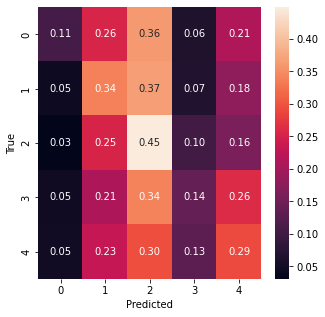

100%|██████████| 28/28 [00:05<00:00,  5.03it/s]


VALIDATION - Time: 5.6s - Loss: 1.5890584545476099


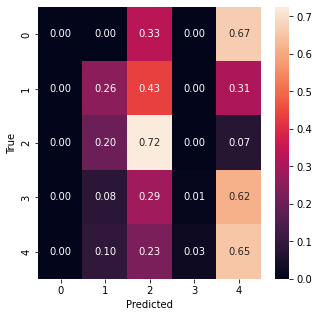

* Epoch 38 / 180


100%|██████████| 158/158 [00:55<00:00,  2.84it/s]


TRAIN - Time: 55.7s - Loss: 1.5248422411423692


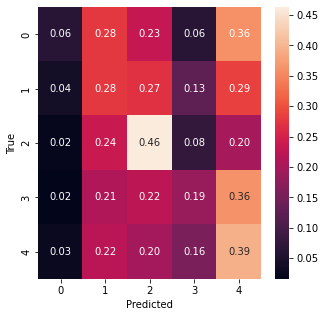

100%|██████████| 28/28 [00:05<00:00,  4.99it/s]


VALIDATION - Time: 5.6s - Loss: 1.5268769604819161


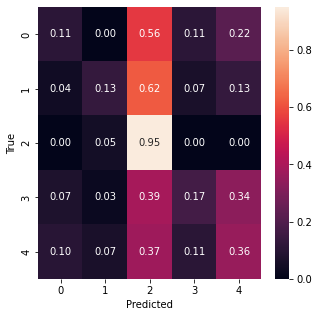

* Epoch 39 / 180


100%|██████████| 158/158 [00:55<00:00,  2.83it/s]


TRAIN - Time: 55.8s - Loss: 1.5423516929149619


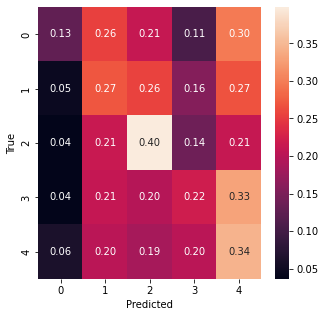

100%|██████████| 28/28 [00:05<00:00,  5.00it/s]


VALIDATION - Time: 5.6s - Loss: 1.4838739080088486


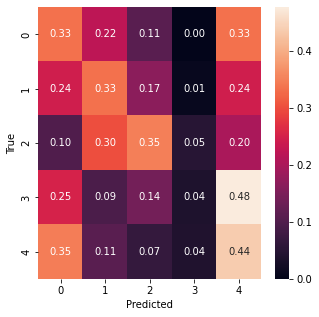

* Epoch 40 / 180


100%|██████████| 158/158 [00:58<00:00,  2.70it/s]


TRAIN - Time: 58.6s - Loss: 1.5056177890753444


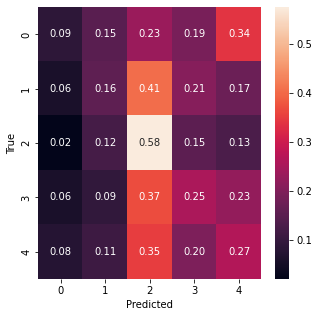

100%|██████████| 28/28 [00:06<00:00,  4.64it/s]


VALIDATION - Time: 6.0s - Loss: 1.4672807923385074


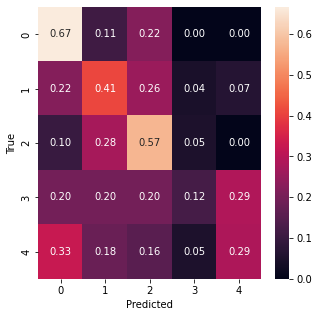

* Epoch 41 / 180


100%|██████████| 158/158 [01:01<00:00,  2.56it/s]


TRAIN - Time: 61.7s - Loss: 1.50812257392497


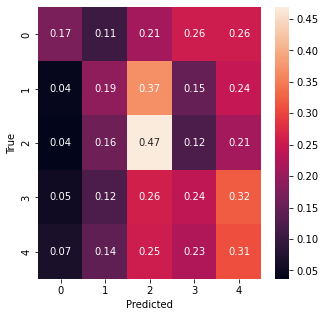

100%|██████████| 28/28 [00:06<00:00,  4.48it/s]


VALIDATION - Time: 6.3s - Loss: 1.6090108922549655


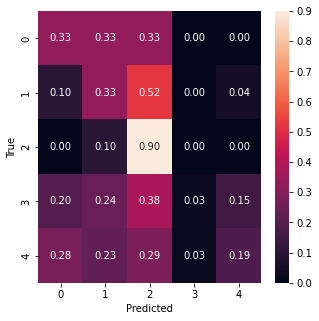

* Epoch 42 / 180


100%|██████████| 158/158 [00:59<00:00,  2.66it/s]


TRAIN - Time: 59.5s - Loss: 1.5263842540451245


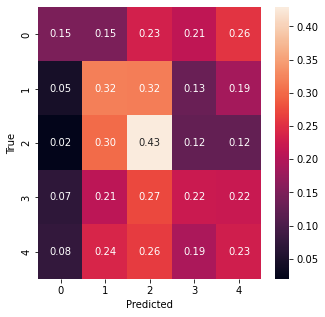

100%|██████████| 28/28 [00:06<00:00,  4.56it/s]


VALIDATION - Time: 6.2s - Loss: 1.4791837441069742


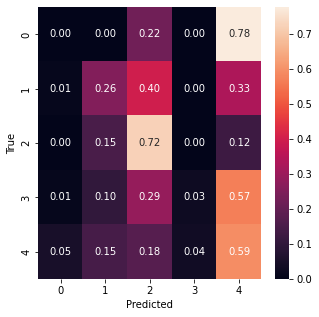

* Epoch 43 / 180


100%|██████████| 158/158 [00:59<00:00,  2.66it/s]


TRAIN - Time: 59.5s - Loss: 1.4931844216358814


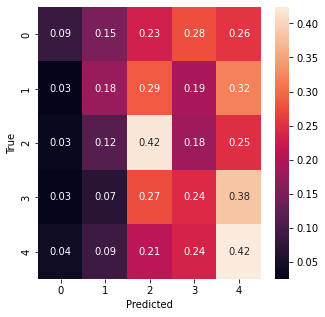

100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


VALIDATION - Time: 6.6s - Loss: 1.4134524741343086


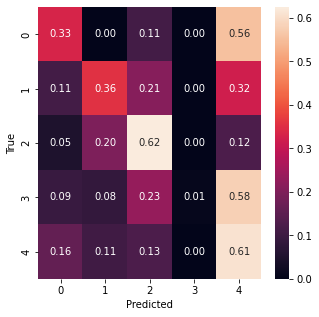

* Epoch 44 / 180


100%|██████████| 158/158 [01:03<00:00,  2.49it/s]


TRAIN - Time: 63.3s - Loss: 1.4920781869677051


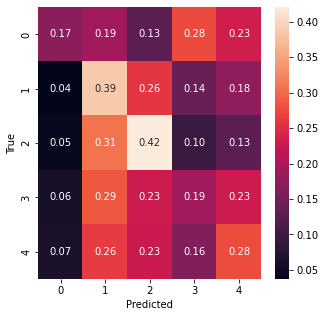

100%|██████████| 28/28 [00:05<00:00,  4.74it/s]


VALIDATION - Time: 5.9s - Loss: 1.538140797189304


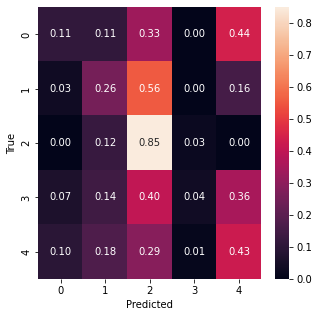

* Epoch 45 / 180


100%|██████████| 158/158 [00:58<00:00,  2.72it/s]


TRAIN - Time: 58.1s - Loss: 1.4943348531481593


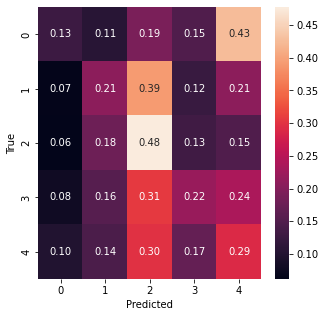

100%|██████████| 28/28 [00:05<00:00,  4.72it/s]


VALIDATION - Time: 5.9s - Loss: 1.692289220435279


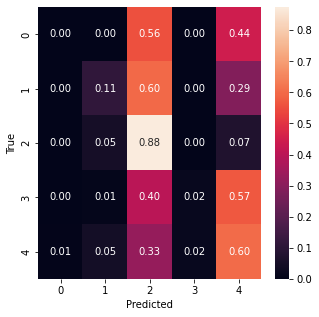

* Epoch 46 / 180


100%|██████████| 158/158 [00:57<00:00,  2.73it/s]


TRAIN - Time: 57.9s - Loss: 1.4928736045390731


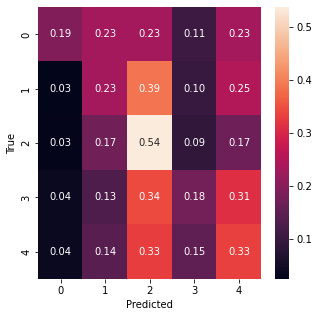

100%|██████████| 28/28 [00:05<00:00,  4.75it/s]


VALIDATION - Time: 5.9s - Loss: 1.4439198502472466


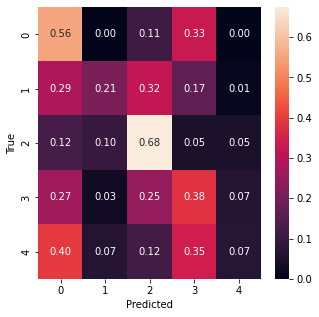

* Epoch 47 / 180


100%|██████████| 158/158 [00:58<00:00,  2.72it/s]


TRAIN - Time: 58.1s - Loss: 1.5032539571387855


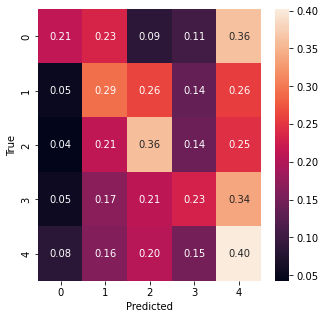

100%|██████████| 28/28 [00:05<00:00,  4.83it/s]


VALIDATION - Time: 5.8s - Loss: 1.4705471694469456


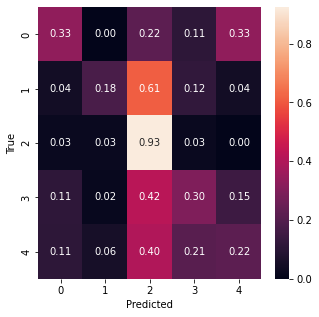

* Epoch 48 / 180


100%|██████████| 158/158 [00:58<00:00,  2.72it/s]


TRAIN - Time: 58.1s - Loss: 1.4933484973786755


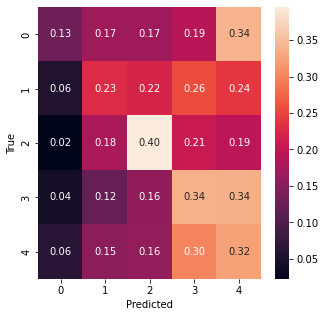

100%|██████████| 28/28 [00:05<00:00,  4.84it/s]


VALIDATION - Time: 5.8s - Loss: 1.4331612374101363


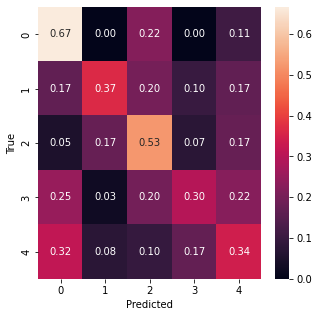

* Epoch 49 / 180


100%|██████████| 158/158 [01:00<00:00,  2.59it/s]


TRAIN - Time: 61.0s - Loss: 1.4959283716316456


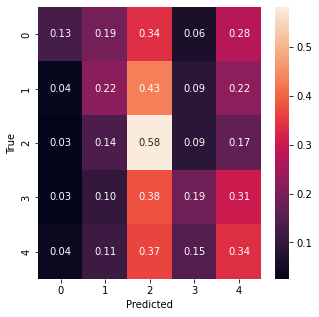

100%|██████████| 28/28 [00:05<00:00,  4.93it/s]


VALIDATION - Time: 5.7s - Loss: 1.4462923769439968


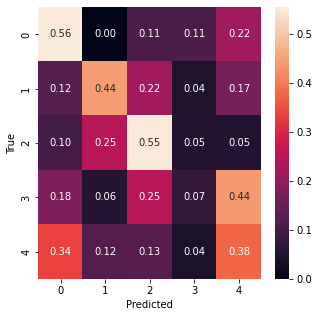

* Epoch 50 / 180


100%|██████████| 158/158 [00:58<00:00,  2.68it/s]


TRAIN - Time: 59.0s - Loss: 1.5145603806912145


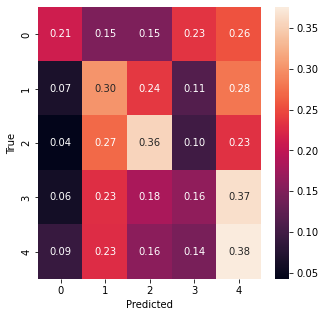

100%|██████████| 28/28 [00:06<00:00,  4.44it/s]


VALIDATION - Time: 6.3s - Loss: 1.4413975690092355


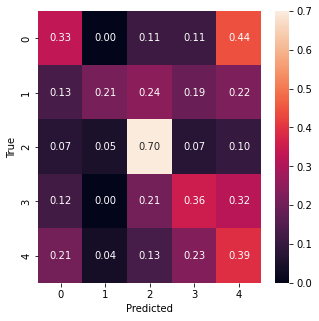

* Epoch 51 / 180


100%|██████████| 158/158 [00:58<00:00,  2.71it/s]


TRAIN - Time: 58.4s - Loss: 1.5028308833701702


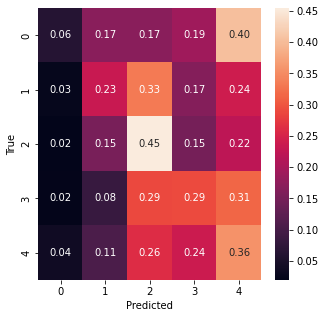

100%|██████████| 28/28 [00:05<00:00,  4.83it/s]


VALIDATION - Time: 5.8s - Loss: 1.4012811460665293


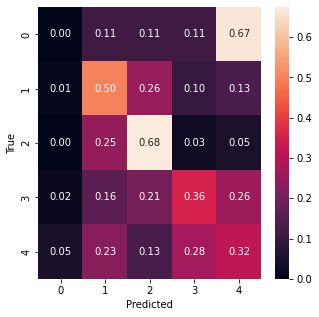

* Epoch 52 / 180


100%|██████████| 158/158 [00:59<00:00,  2.64it/s]


TRAIN - Time: 59.9s - Loss: 1.5025468513935432


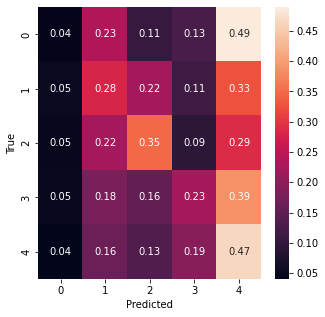

100%|██████████| 28/28 [00:05<00:00,  4.94it/s]


VALIDATION - Time: 5.7s - Loss: 1.3946306109428408


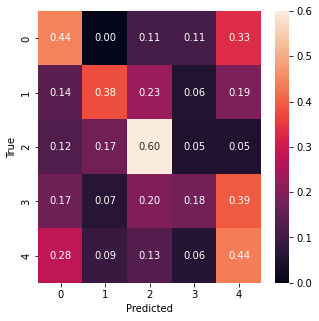

* Epoch 53 / 180


100%|██████████| 158/158 [01:00<00:00,  2.61it/s]


TRAIN - Time: 60.6s - Loss: 1.5009202700627


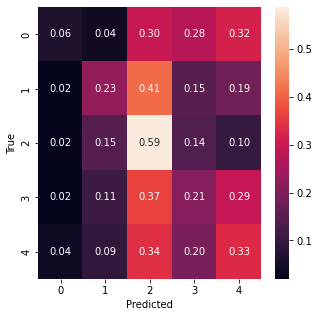

100%|██████████| 28/28 [00:06<00:00,  4.65it/s]


VALIDATION - Time: 6.0s - Loss: 1.3823675470692771


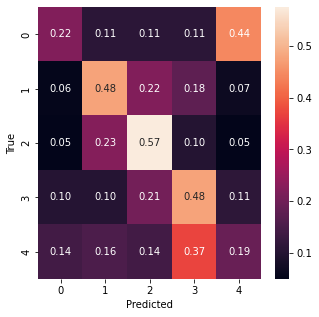

* Epoch 54 / 180


100%|██████████| 158/158 [00:58<00:00,  2.69it/s]


TRAIN - Time: 58.7s - Loss: 1.4959409633014775


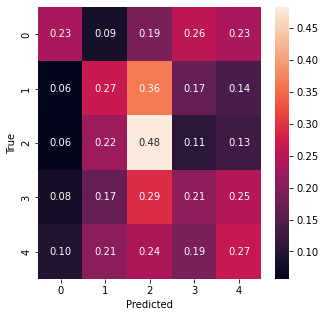

100%|██████████| 28/28 [00:05<00:00,  4.94it/s]


VALIDATION - Time: 5.7s - Loss: 1.389631769486836


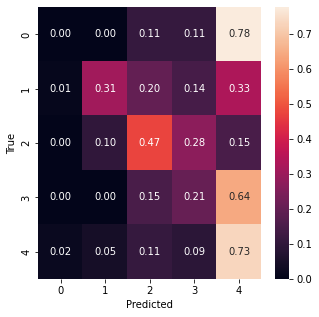

* Epoch 55 / 180


100%|██████████| 158/158 [00:57<00:00,  2.76it/s]


TRAIN - Time: 57.4s - Loss: 1.4854410358622108


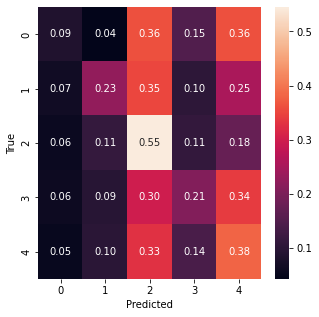

100%|██████████| 28/28 [00:05<00:00,  4.85it/s]


VALIDATION - Time: 5.8s - Loss: 1.396975106426648


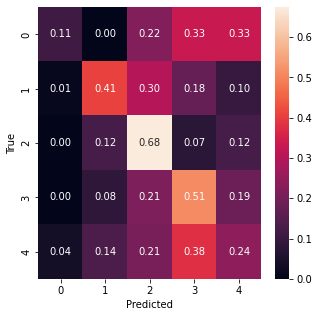

* Epoch 56 / 180


100%|██████████| 158/158 [00:57<00:00,  2.75it/s]


TRAIN - Time: 57.4s - Loss: 1.4821559190750127


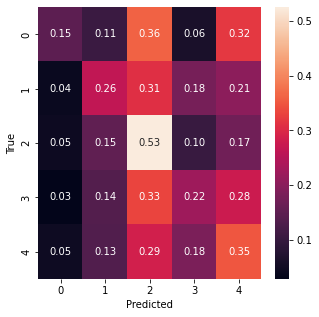

100%|██████████| 28/28 [00:05<00:00,  4.72it/s]


VALIDATION - Time: 5.9s - Loss: 1.3868782094546726


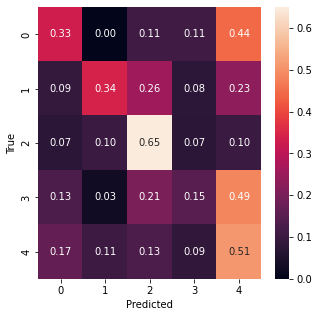

* Epoch 57 / 180


100%|██████████| 158/158 [00:57<00:00,  2.73it/s]


TRAIN - Time: 57.8s - Loss: 1.4761061177978028


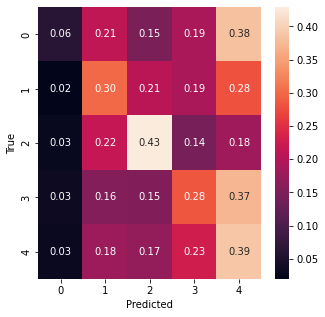

100%|██████████| 28/28 [00:05<00:00,  4.81it/s]


VALIDATION - Time: 5.8s - Loss: 1.3967437211956295


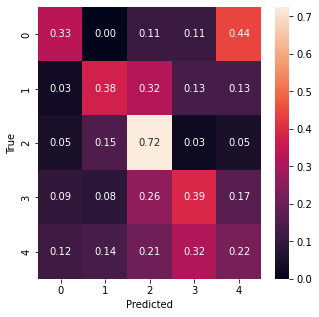

* Epoch 58 / 180


100%|██████████| 158/158 [01:00<00:00,  2.60it/s]


TRAIN - Time: 60.8s - Loss: 1.503236806090874


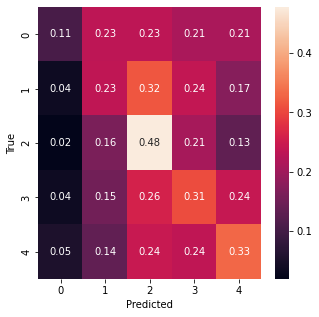

100%|██████████| 28/28 [00:05<00:00,  4.82it/s]


VALIDATION - Time: 5.8s - Loss: 1.4262163128171648


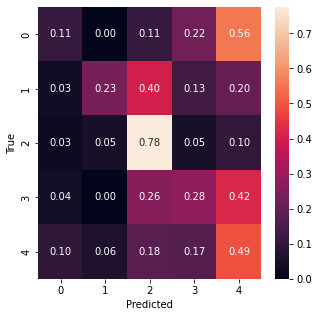

* Epoch 59 / 180


100%|██████████| 158/158 [00:57<00:00,  2.75it/s]


TRAIN - Time: 57.4s - Loss: 1.4905568874334985


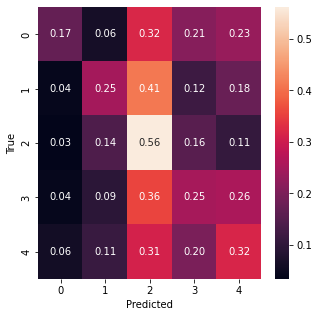

100%|██████████| 28/28 [00:05<00:00,  4.82it/s]


VALIDATION - Time: 5.8s - Loss: 1.385061887758119


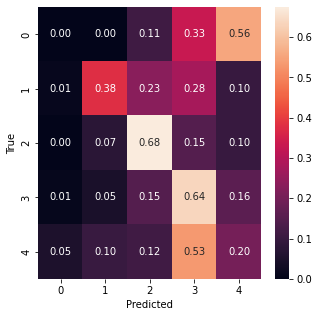

* Epoch 60 / 180


100%|██████████| 158/158 [00:57<00:00,  2.74it/s]


TRAIN - Time: 57.7s - Loss: 1.4610317737995826


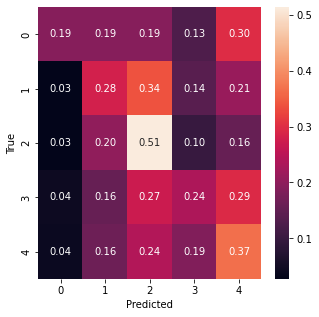

100%|██████████| 28/28 [00:05<00:00,  4.87it/s]


VALIDATION - Time: 5.8s - Loss: 1.3701357500893732


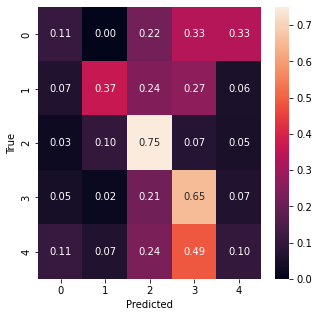

* Epoch 61 / 180


100%|██████████| 158/158 [00:58<00:00,  2.72it/s]


TRAIN - Time: 58.2s - Loss: 1.4619200848325904


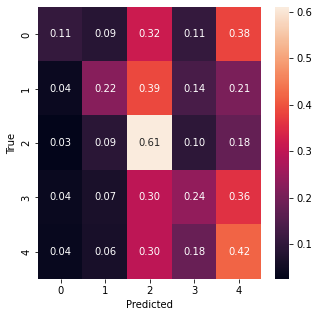

100%|██████████| 28/28 [00:05<00:00,  4.80it/s]


VALIDATION - Time: 5.8s - Loss: 1.453350386449269


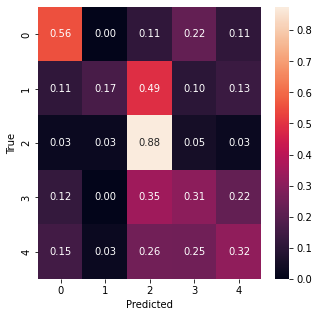

* Epoch 62 / 180


100%|██████████| 158/158 [01:00<00:00,  2.63it/s]


TRAIN - Time: 60.2s - Loss: 1.4674051245556603


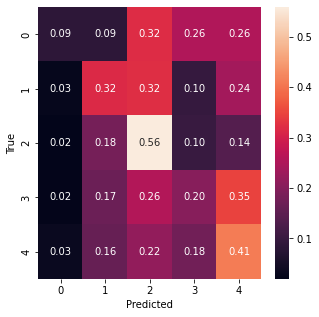

100%|██████████| 28/28 [00:05<00:00,  4.74it/s]


VALIDATION - Time: 5.9s - Loss: 1.4121925085783005


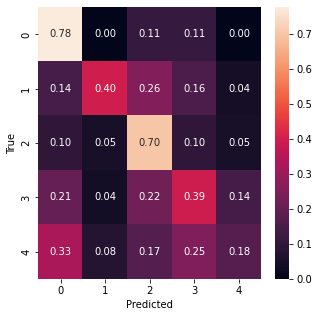

* Epoch 63 / 180


100%|██████████| 158/158 [00:57<00:00,  2.74it/s]


TRAIN - Time: 57.8s - Loss: 1.4455999203875094


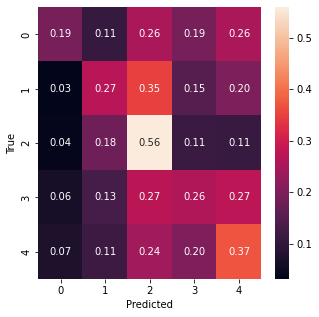

100%|██████████| 28/28 [00:05<00:00,  4.75it/s]


VALIDATION - Time: 5.9s - Loss: 1.3684012889862058


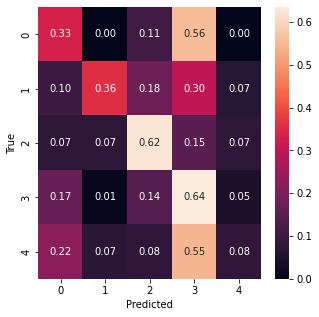

* Epoch 64 / 180


100%|██████████| 158/158 [00:58<00:00,  2.71it/s]


TRAIN - Time: 58.4s - Loss: 1.4940260626092738


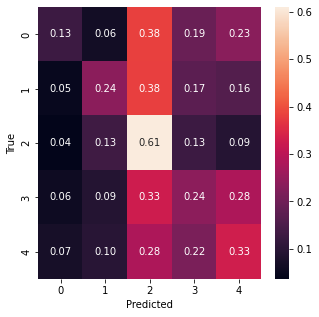

100%|██████████| 28/28 [00:06<00:00,  4.61it/s]


VALIDATION - Time: 6.1s - Loss: 1.3184298362050737


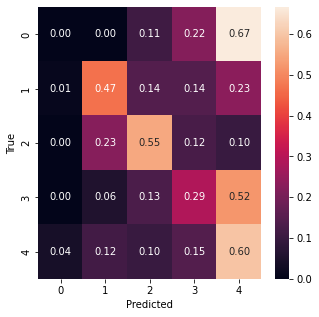

* Epoch 65 / 180


100%|██████████| 158/158 [00:59<00:00,  2.65it/s]


TRAIN - Time: 59.7s - Loss: 1.4400520796262763


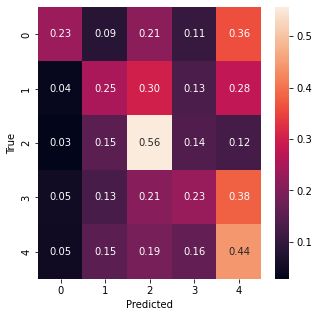

100%|██████████| 28/28 [00:05<00:00,  4.73it/s]


VALIDATION - Time: 5.9s - Loss: 1.3124335195337022


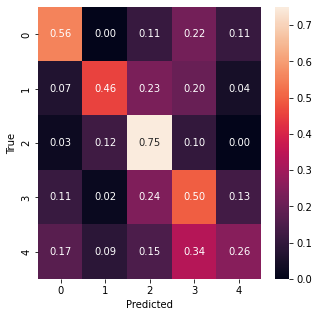

* Epoch 66 / 180


100%|██████████| 158/158 [01:03<00:00,  2.51it/s]


TRAIN - Time: 63.0s - Loss: 1.4594852916802032


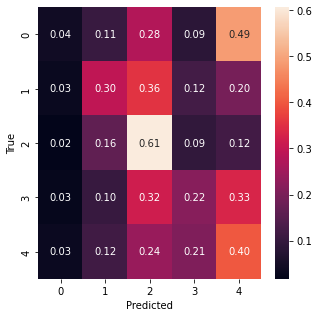

100%|██████████| 28/28 [00:05<00:00,  4.71it/s]


VALIDATION - Time: 6.0s - Loss: 1.4191753906863076


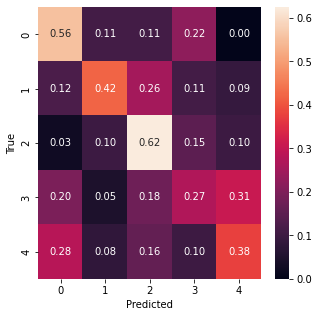

* Epoch 67 / 180


100%|██████████| 158/158 [00:59<00:00,  2.67it/s]


TRAIN - Time: 59.1s - Loss: 1.4578834485404095


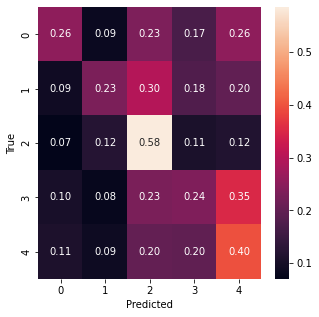

100%|██████████| 28/28 [00:05<00:00,  4.68it/s]


VALIDATION - Time: 6.0s - Loss: 1.3081792678151811


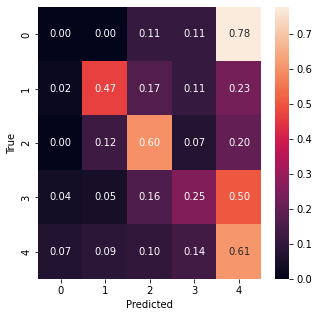

* Epoch 68 / 180


100%|██████████| 158/158 [01:00<00:00,  2.63it/s]


TRAIN - Time: 60.2s - Loss: 1.441296458244324


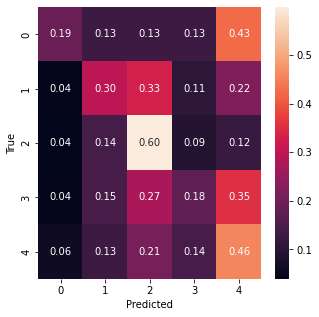

100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


VALIDATION - Time: 5.9s - Loss: 1.3266675429684776


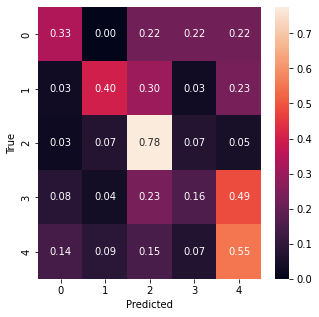

* Epoch 69 / 180


100%|██████████| 158/158 [01:00<00:00,  2.60it/s]


TRAIN - Time: 60.9s - Loss: 1.452534544694273


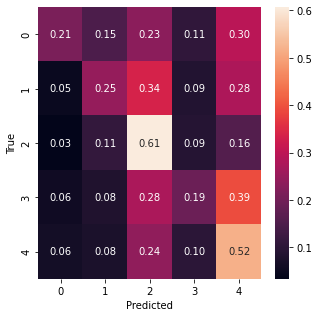

100%|██████████| 28/28 [00:06<00:00,  4.67it/s]


VALIDATION - Time: 6.0s - Loss: 1.4033856881516322


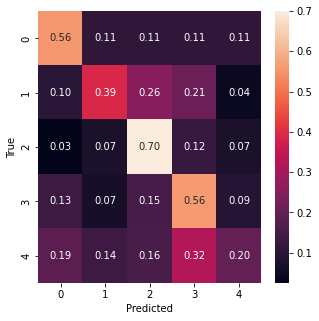

* Epoch 70 / 180


100%|██████████| 158/158 [01:00<00:00,  2.59it/s]


TRAIN - Time: 61.0s - Loss: 1.4559792861153813


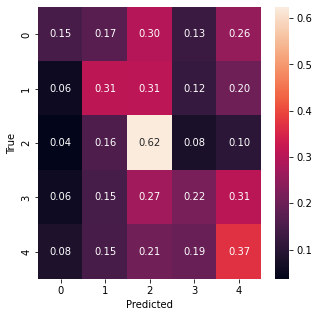

100%|██████████| 28/28 [00:06<00:00,  4.58it/s]


VALIDATION - Time: 6.1s - Loss: 1.3584649988583157


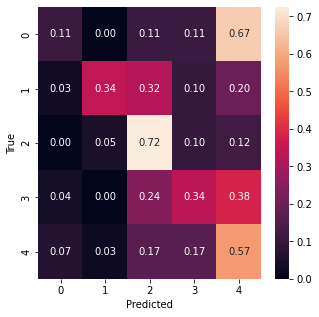

* Epoch 71 / 180


100%|██████████| 158/158 [00:58<00:00,  2.71it/s]


TRAIN - Time: 58.3s - Loss: 1.4298726418350323


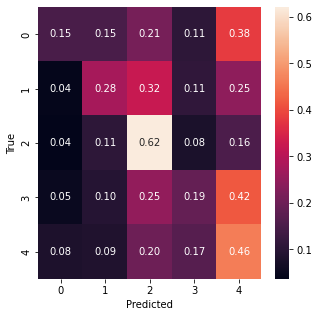

100%|██████████| 28/28 [00:06<00:00,  4.41it/s]


VALIDATION - Time: 6.4s - Loss: 1.482149709548269


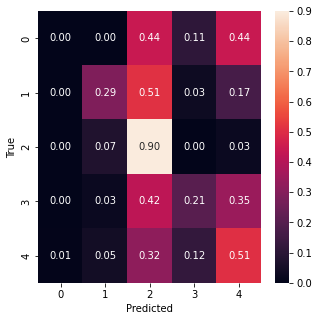

* Epoch 72 / 180


100%|██████████| 158/158 [01:00<00:00,  2.60it/s]


TRAIN - Time: 60.8s - Loss: 1.4504763257654405


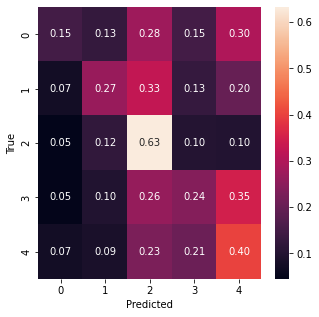

100%|██████████| 28/28 [00:06<00:00,  4.53it/s]


VALIDATION - Time: 6.2s - Loss: 1.2817871804748262


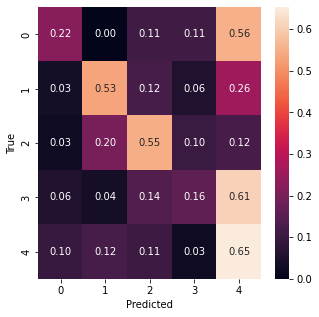

* Epoch 73 / 180


100%|██████████| 158/158 [01:03<00:00,  2.48it/s]


TRAIN - Time: 63.6s - Loss: 1.4219531839406938


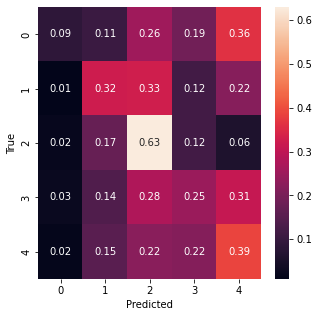

100%|██████████| 28/28 [00:06<00:00,  4.36it/s]


VALIDATION - Time: 6.4s - Loss: 1.3017639879669463


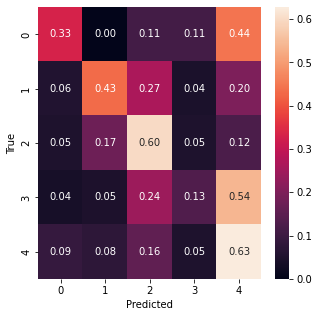

* Epoch 74 / 180


100%|██████████| 158/158 [01:02<00:00,  2.54it/s]


TRAIN - Time: 62.3s - Loss: 1.4181052733071249


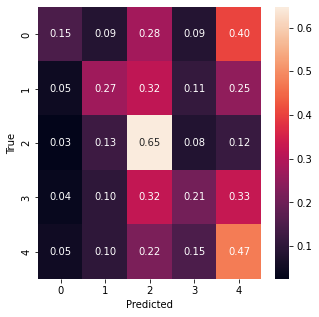

100%|██████████| 28/28 [00:06<00:00,  4.40it/s]


VALIDATION - Time: 6.4s - Loss: 1.317981466650963


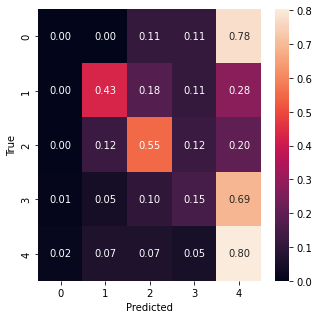

* Epoch 75 / 180


100%|██████████| 158/158 [01:03<00:00,  2.48it/s]


TRAIN - Time: 63.6s - Loss: 1.4031161552743072


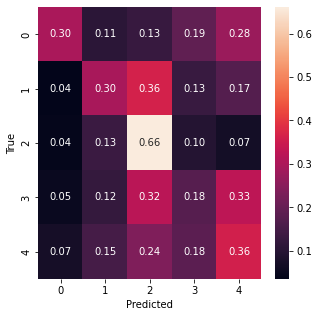

100%|██████████| 28/28 [00:06<00:00,  4.53it/s]


VALIDATION - Time: 6.2s - Loss: 1.3931359116520199


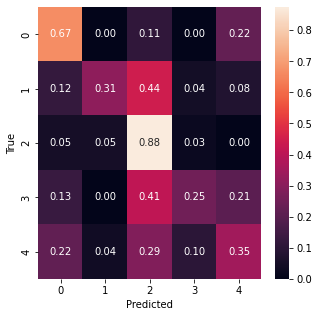

* Epoch 76 / 180


100%|██████████| 158/158 [01:01<00:00,  2.57it/s]


TRAIN - Time: 61.5s - Loss: 1.4395821830139888


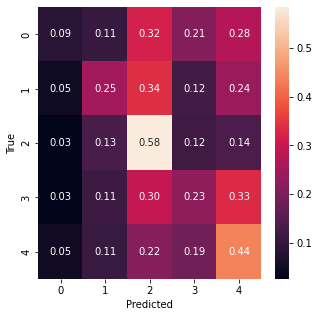

100%|██████████| 28/28 [00:06<00:00,  4.52it/s]


VALIDATION - Time: 6.2s - Loss: 1.3717844230788097


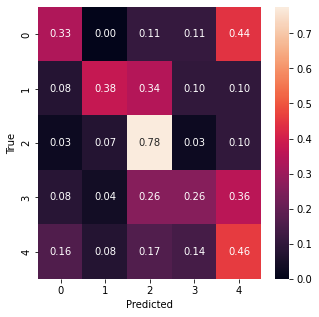

* Epoch 77 / 180


100%|██████████| 158/158 [01:00<00:00,  2.59it/s]


TRAIN - Time: 61.0s - Loss: 1.41195837304562


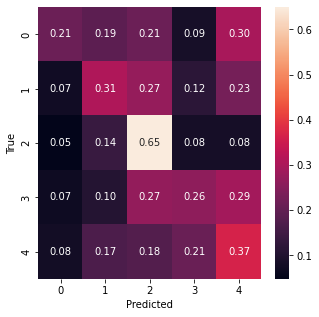

100%|██████████| 28/28 [00:06<00:00,  4.51it/s]


VALIDATION - Time: 6.2s - Loss: 1.3213240887437547


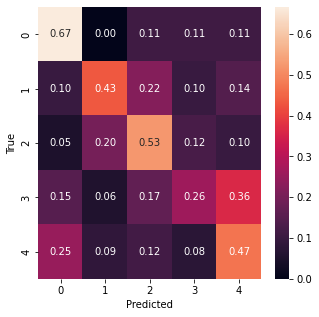

* Epoch 78 / 180


100%|██████████| 158/158 [01:00<00:00,  2.61it/s]


TRAIN - Time: 60.5s - Loss: 1.3967004991784888


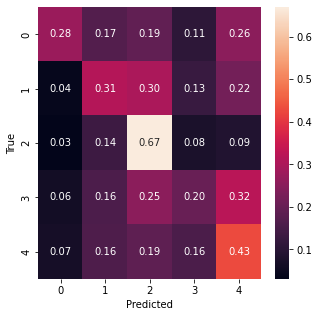

100%|██████████| 28/28 [00:06<00:00,  4.39it/s]


VALIDATION - Time: 6.4s - Loss: 1.3598995442901338


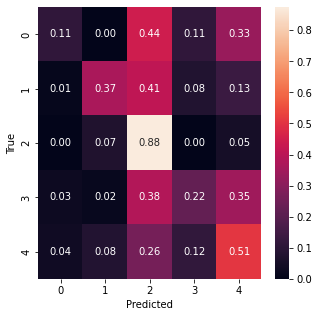

* Epoch 79 / 180


100%|██████████| 158/158 [01:00<00:00,  2.59it/s]


TRAIN - Time: 60.9s - Loss: 1.4067520095577715


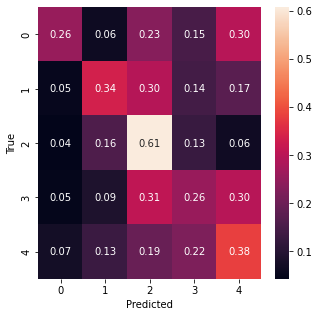

100%|██████████| 28/28 [00:06<00:00,  4.46it/s]


VALIDATION - Time: 6.3s - Loss: 1.3025008418730328


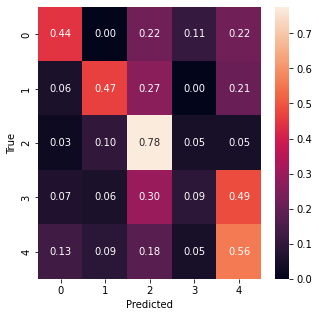

* Epoch 80 / 180


100%|██████████| 158/158 [01:02<00:00,  2.53it/s]


TRAIN - Time: 62.4s - Loss: 1.406042646758164


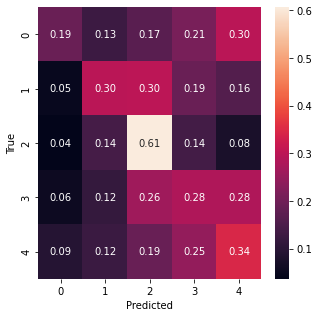

100%|██████████| 28/28 [00:06<00:00,  4.31it/s]


VALIDATION - Time: 6.5s - Loss: 1.2987065421683448


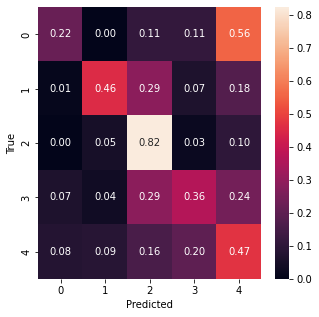

* Epoch 81 / 180


100%|██████████| 158/158 [01:04<00:00,  2.45it/s]


TRAIN - Time: 64.6s - Loss: 1.3918205261984955


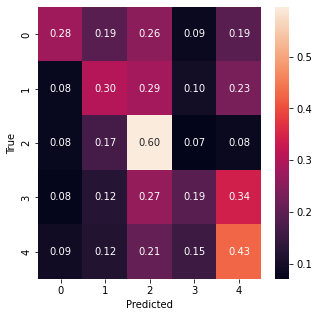

100%|██████████| 28/28 [00:06<00:00,  4.44it/s]


VALIDATION - Time: 6.3s - Loss: 1.321802401116916


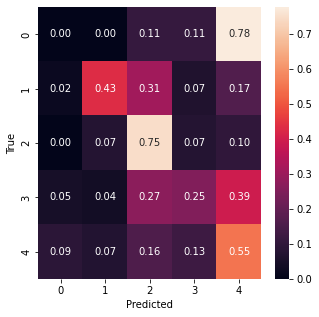

* Epoch 82 / 180


100%|██████████| 158/158 [01:02<00:00,  2.52it/s]


TRAIN - Time: 62.8s - Loss: 1.3822546937043143


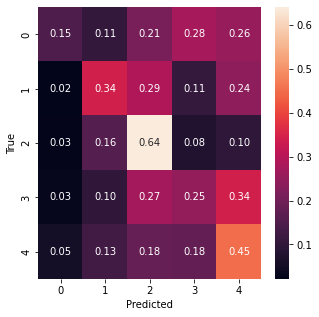

100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


VALIDATION - Time: 6.6s - Loss: 1.373603710106441


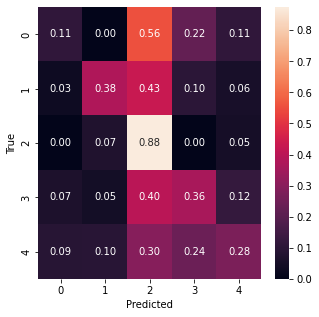

* Epoch 83 / 180


100%|██████████| 158/158 [01:01<00:00,  2.56it/s]


TRAIN - Time: 61.8s - Loss: 1.411604703227176


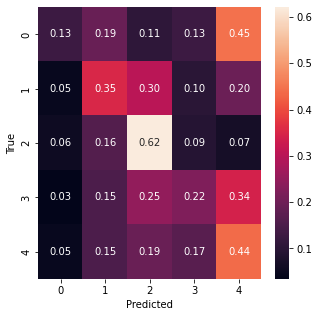

100%|██████████| 28/28 [00:06<00:00,  4.36it/s]


VALIDATION - Time: 6.4s - Loss: 1.2478380522557668


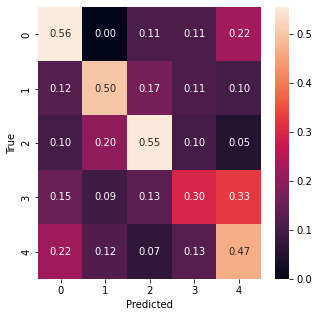

* Epoch 84 / 180


100%|██████████| 158/158 [01:02<00:00,  2.52it/s]


TRAIN - Time: 62.6s - Loss: 1.408098177819313


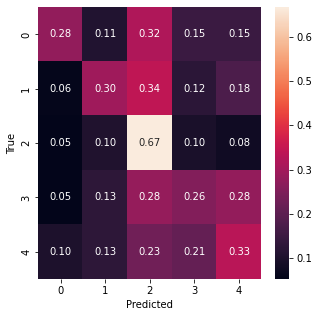

100%|██████████| 28/28 [00:06<00:00,  4.61it/s]


VALIDATION - Time: 6.1s - Loss: 1.2987770374332155


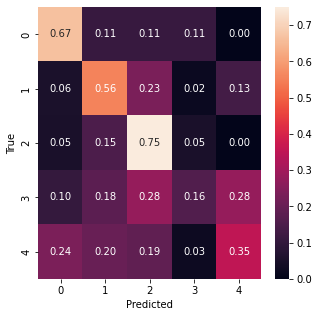

* Epoch 85 / 180


100%|██████████| 158/158 [01:00<00:00,  2.63it/s]


TRAIN - Time: 60.2s - Loss: 1.3981955915312234


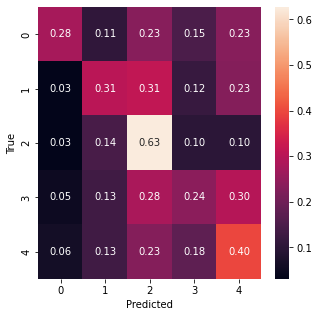

100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


VALIDATION - Time: 6.6s - Loss: 1.3185318708419798


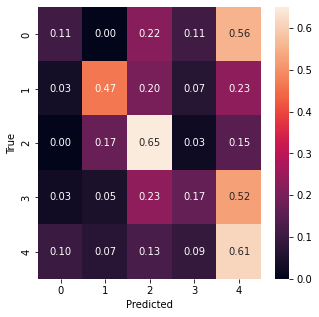

* Epoch 86 / 180


100%|██████████| 158/158 [01:00<00:00,  2.60it/s]


TRAIN - Time: 60.7s - Loss: 1.4109963223903987


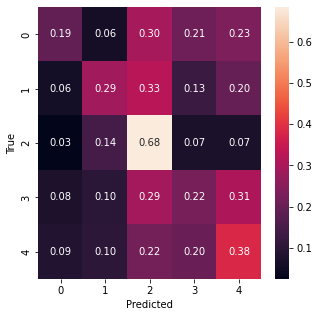

100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


VALIDATION - Time: 7.5s - Loss: 1.3027166915791373


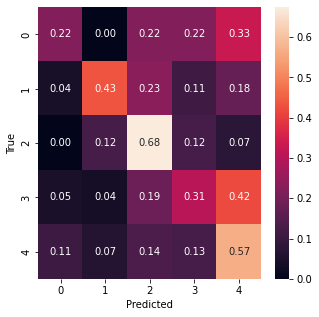

* Epoch 87 / 180


100%|██████████| 158/158 [01:01<00:00,  2.57it/s]


TRAIN - Time: 61.6s - Loss: 1.3918927492974675


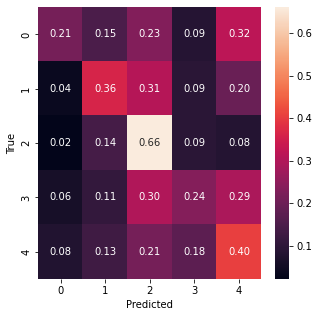

100%|██████████| 28/28 [00:06<00:00,  4.57it/s]


VALIDATION - Time: 6.1s - Loss: 1.2655713047300068


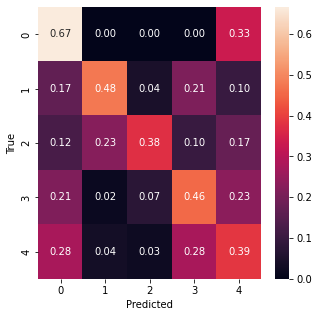

* Epoch 88 / 180


100%|██████████| 158/158 [01:01<00:00,  2.56it/s]


TRAIN - Time: 61.8s - Loss: 1.3910318394250518


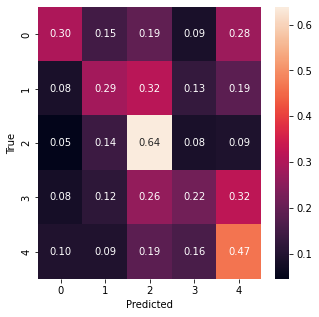

100%|██████████| 28/28 [00:06<00:00,  4.52it/s]


VALIDATION - Time: 6.2s - Loss: 1.3610016405582428


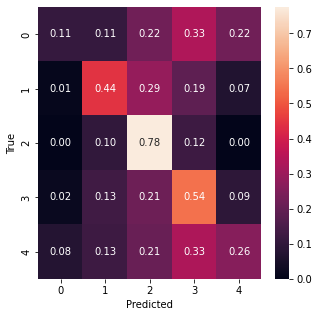

* Epoch 89 / 180


100%|██████████| 158/158 [01:03<00:00,  2.50it/s]


TRAIN - Time: 63.2s - Loss: 1.3913137599637235


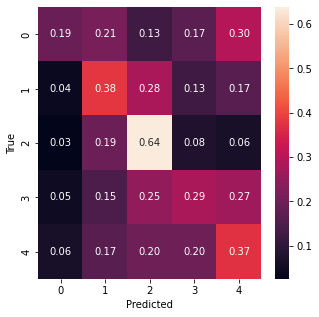

100%|██████████| 28/28 [00:06<00:00,  4.53it/s]


VALIDATION - Time: 6.2s - Loss: 1.3029936126300272


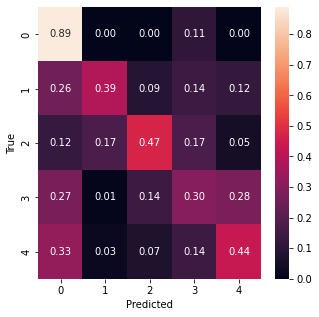

* Epoch 90 / 180


100%|██████████| 158/158 [01:02<00:00,  2.55it/s]


TRAIN - Time: 62.1s - Loss: 1.4009565741200984


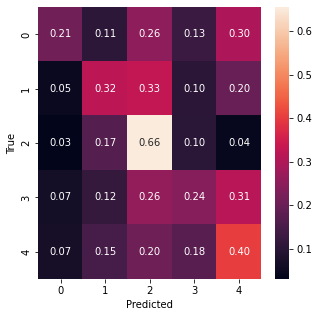

100%|██████████| 28/28 [00:06<00:00,  4.45it/s]


VALIDATION - Time: 6.3s - Loss: 1.2919584150825225


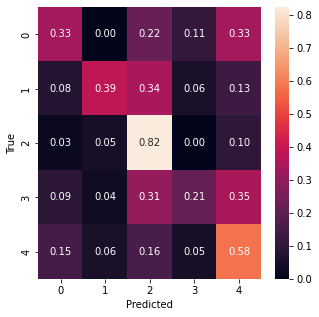

* Epoch 91 / 180


100%|██████████| 158/158 [00:59<00:00,  2.64it/s]


TRAIN - Time: 59.9s - Loss: 1.4056595213051082


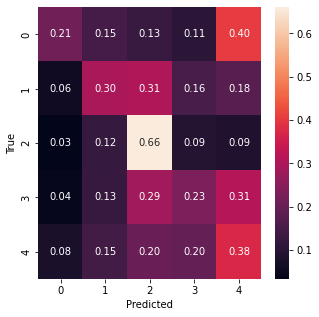

100%|██████████| 28/28 [00:06<00:00,  4.59it/s]


VALIDATION - Time: 6.1s - Loss: 1.319785769496645


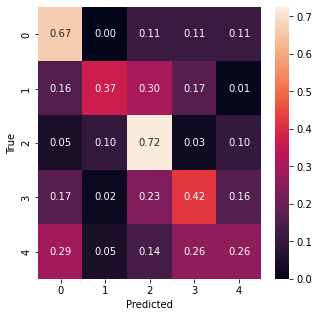

* Epoch 92 / 180


100%|██████████| 158/158 [01:02<00:00,  2.51it/s]


TRAIN - Time: 62.9s - Loss: 1.3985983114453808


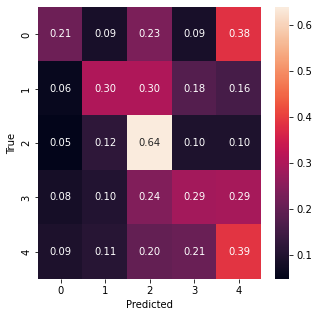

100%|██████████| 28/28 [00:06<00:00,  4.30it/s]


VALIDATION - Time: 6.5s - Loss: 1.2711357282740732


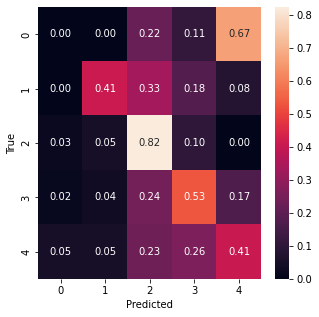

* Epoch 93 / 180


100%|██████████| 158/158 [01:02<00:00,  2.53it/s]


TRAIN - Time: 62.4s - Loss: 1.3962335892115965


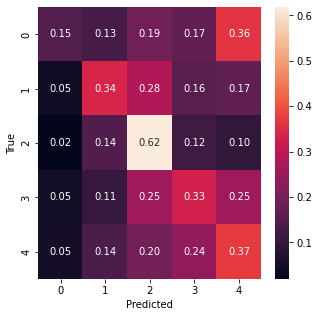

100%|██████████| 28/28 [00:06<00:00,  4.57it/s]


VALIDATION - Time: 6.1s - Loss: 1.2370306615318571


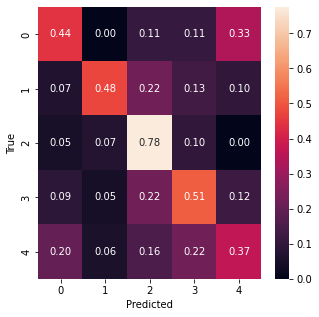

* Epoch 94 / 180


100%|██████████| 158/158 [01:03<00:00,  2.47it/s]


TRAIN - Time: 64.0s - Loss: 1.3722131557856936


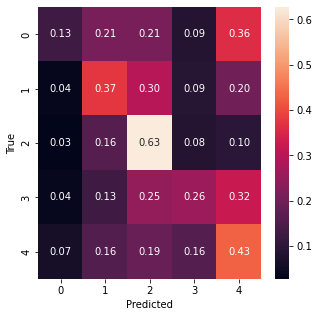

100%|██████████| 28/28 [00:06<00:00,  4.55it/s]


VALIDATION - Time: 6.2s - Loss: 1.3057704333748132


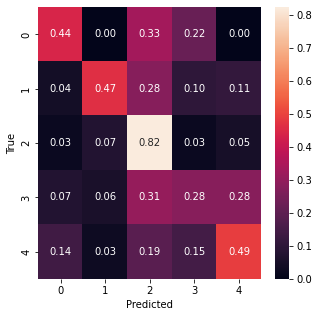

* Epoch 95 / 180


100%|██████████| 158/158 [01:04<00:00,  2.46it/s]


TRAIN - Time: 64.3s - Loss: 1.3787465634979783


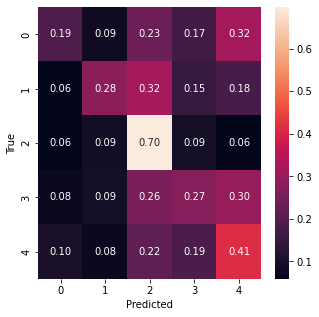

100%|██████████| 28/28 [00:06<00:00,  4.40it/s]


VALIDATION - Time: 6.4s - Loss: 1.3345327356031962


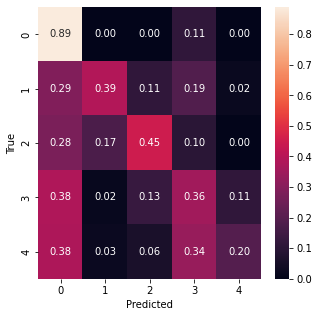

* Epoch 96 / 180


100%|██████████| 158/158 [01:03<00:00,  2.48it/s]


TRAIN - Time: 63.6s - Loss: 1.3938722172869915


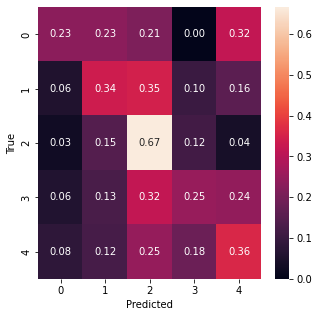

100%|██████████| 28/28 [00:06<00:00,  4.51it/s]


VALIDATION - Time: 6.2s - Loss: 1.3215374180248805


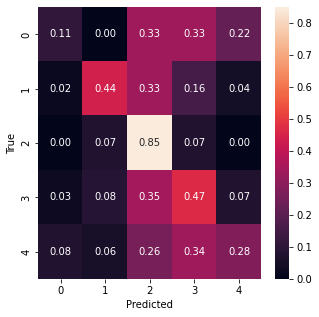

* Epoch 97 / 180


100%|██████████| 158/158 [01:01<00:00,  2.57it/s]


TRAIN - Time: 61.5s - Loss: 1.3450724648523933


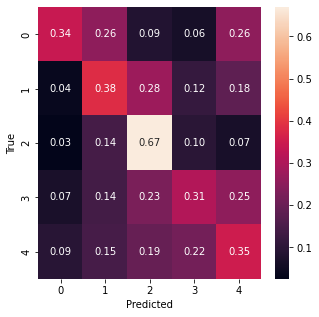

100%|██████████| 28/28 [00:06<00:00,  4.33it/s]


VALIDATION - Time: 6.5s - Loss: 1.3049734639269963


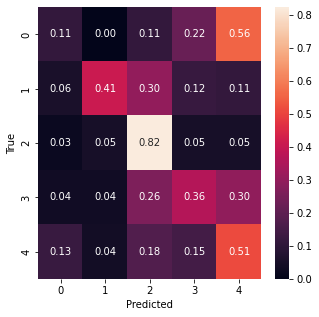

* Epoch 98 / 180


100%|██████████| 158/158 [01:02<00:00,  2.51it/s]


TRAIN - Time: 63.0s - Loss: 1.3669852497456958


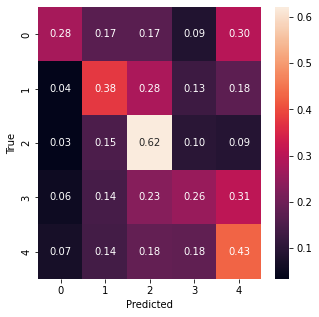

100%|██████████| 28/28 [00:06<00:00,  4.57it/s]


VALIDATION - Time: 6.1s - Loss: 1.2945235030991689


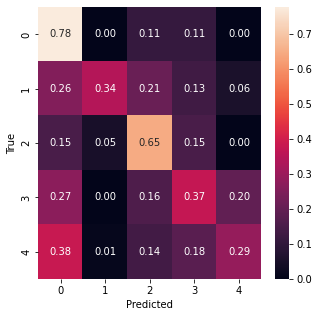

* Epoch 99 / 180


100%|██████████| 158/158 [01:01<00:00,  2.59it/s]


TRAIN - Time: 61.1s - Loss: 1.3773303922218612


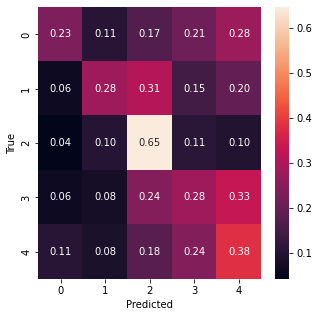

100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


VALIDATION - Time: 6.6s - Loss: 1.228864559105464


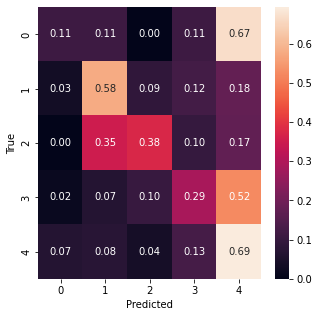

* Epoch 100 / 180


100%|██████████| 158/158 [01:02<00:00,  2.51it/s]


TRAIN - Time: 62.9s - Loss: 1.3789030705826193


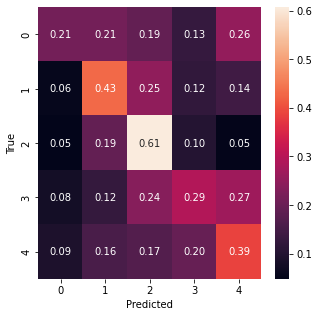

100%|██████████| 28/28 [00:06<00:00,  4.52it/s]


VALIDATION - Time: 6.2s - Loss: 1.2951471912009374


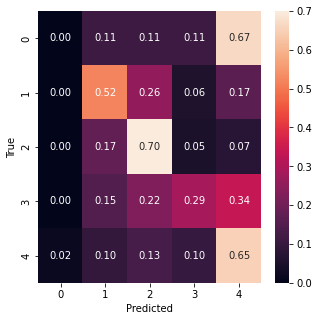

* Epoch 101 / 180


100%|██████████| 158/158 [01:02<00:00,  2.52it/s]


TRAIN - Time: 62.7s - Loss: 1.4143138784396487


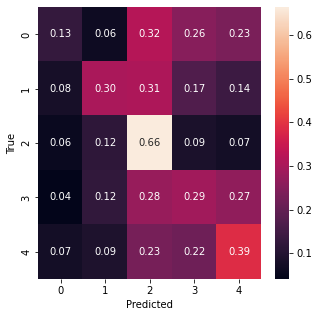

100%|██████████| 28/28 [00:06<00:00,  4.58it/s]


VALIDATION - Time: 6.1s - Loss: 1.2748704659087318


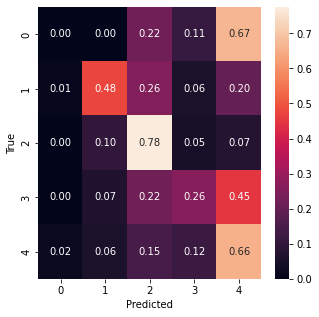

* Epoch 102 / 180


100%|██████████| 158/158 [01:01<00:00,  2.55it/s]


TRAIN - Time: 62.0s - Loss: 1.3714462571506267


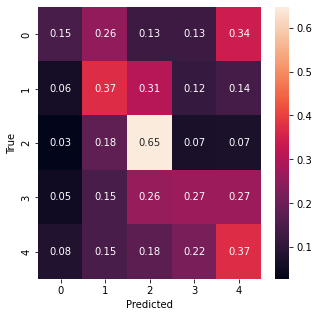

100%|██████████| 28/28 [00:06<00:00,  4.45it/s]


VALIDATION - Time: 6.3s - Loss: 1.3343259905065807


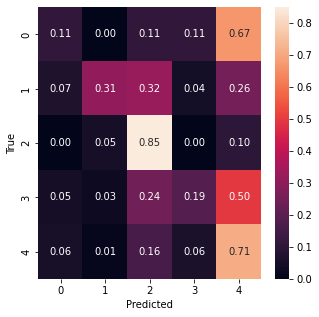

* Epoch 103 / 180


100%|██████████| 158/158 [01:01<00:00,  2.56it/s]


TRAIN - Time: 61.7s - Loss: 1.3943125250973276


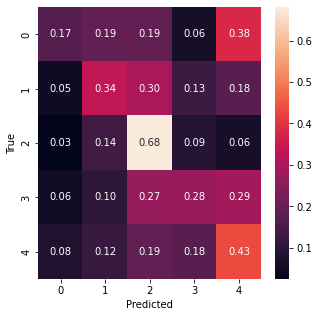

100%|██████████| 28/28 [00:06<00:00,  4.49it/s]


VALIDATION - Time: 6.2s - Loss: 1.2302562211241042


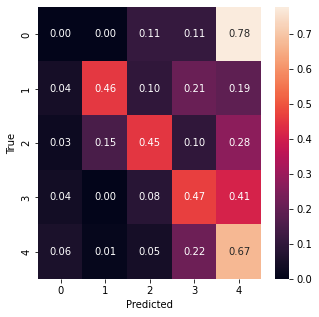

* Epoch 104 / 180


100%|██████████| 158/158 [01:02<00:00,  2.52it/s]


TRAIN - Time: 62.6s - Loss: 1.3452775259561172


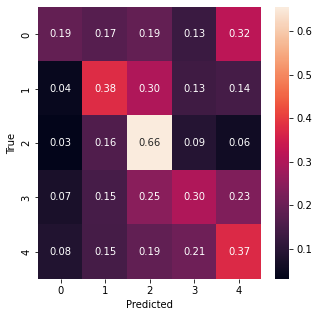

100%|██████████| 28/28 [00:06<00:00,  4.47it/s]


VALIDATION - Time: 6.3s - Loss: 1.2500470727682114


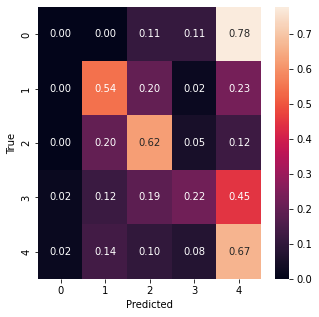

* Epoch 105 / 180


100%|██████████| 158/158 [01:02<00:00,  2.54it/s]


TRAIN - Time: 62.1s - Loss: 1.3547790265536002


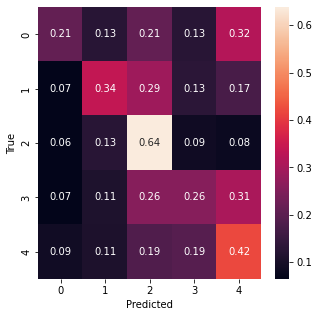

100%|██████████| 28/28 [00:06<00:00,  4.41it/s]


VALIDATION - Time: 6.4s - Loss: 1.1949315454278673


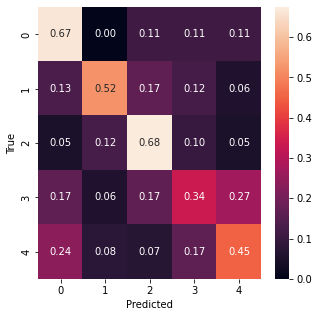

* Epoch 106 / 180


100%|██████████| 158/158 [01:02<00:00,  2.53it/s]


TRAIN - Time: 62.5s - Loss: 1.3664721639095987


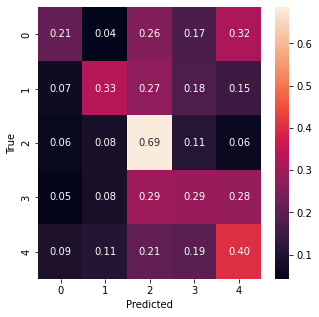

100%|██████████| 28/28 [00:06<00:00,  4.27it/s]


VALIDATION - Time: 6.6s - Loss: 1.1947468242474966


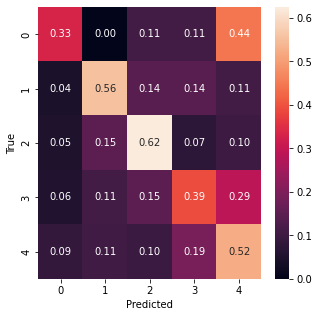

* Epoch 107 / 180


100%|██████████| 158/158 [01:05<00:00,  2.43it/s]


TRAIN - Time: 65.0s - Loss: 1.3449455756175377


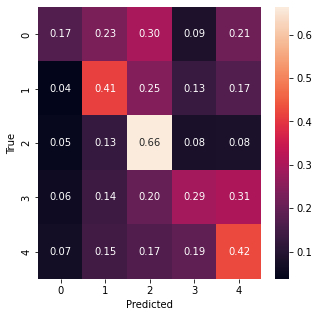

100%|██████████| 28/28 [00:06<00:00,  4.43it/s]


VALIDATION - Time: 6.3s - Loss: 1.28029599572931


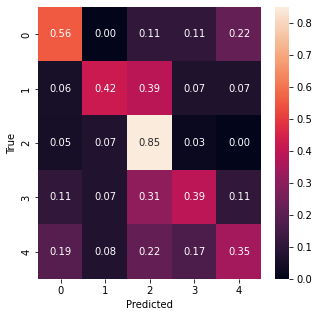

* Epoch 108 / 180


100%|██████████| 158/158 [01:01<00:00,  2.56it/s]


TRAIN - Time: 61.9s - Loss: 1.3345457436163215


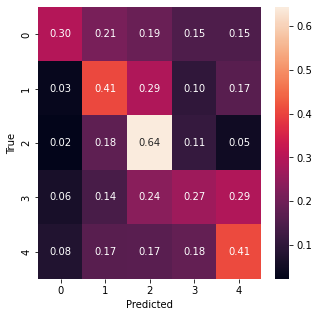

100%|██████████| 28/28 [00:06<00:00,  4.52it/s]


VALIDATION - Time: 6.2s - Loss: 1.2652143154825481


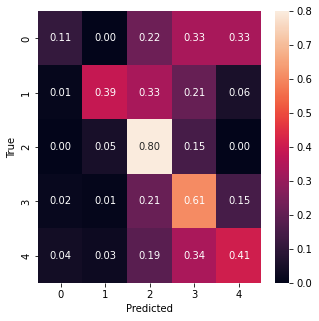

* Epoch 109 / 180


100%|██████████| 158/158 [01:02<00:00,  2.54it/s]


TRAIN - Time: 62.3s - Loss: 1.3307322169406512


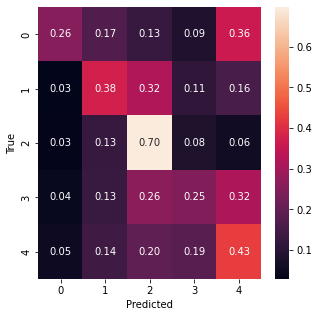

100%|██████████| 28/28 [00:06<00:00,  4.11it/s]


VALIDATION - Time: 6.8s - Loss: 1.3295629684414183


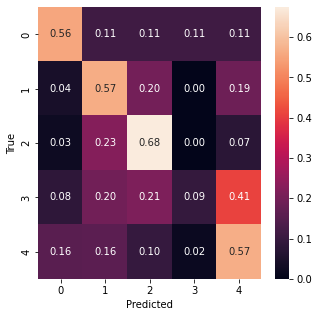

* Epoch 110 / 180


100%|██████████| 158/158 [01:02<00:00,  2.51it/s]


TRAIN - Time: 62.8s - Loss: 1.331072825042507


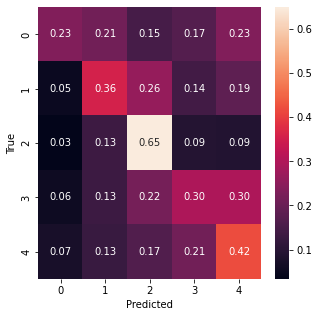

100%|██████████| 28/28 [00:06<00:00,  4.27it/s]


VALIDATION - Time: 6.6s - Loss: 1.3125610841172084


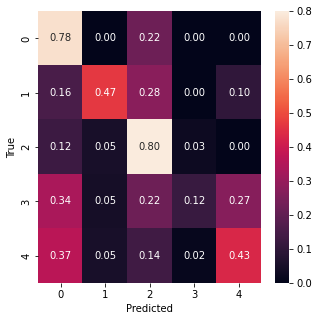

* Epoch 111 / 180


100%|██████████| 158/158 [01:02<00:00,  2.52it/s]


TRAIN - Time: 62.8s - Loss: 1.3559273462506793


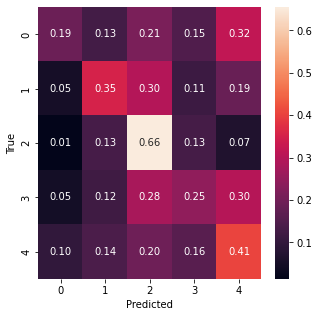

100%|██████████| 28/28 [00:06<00:00,  4.52it/s]


VALIDATION - Time: 6.2s - Loss: 1.197536017213549


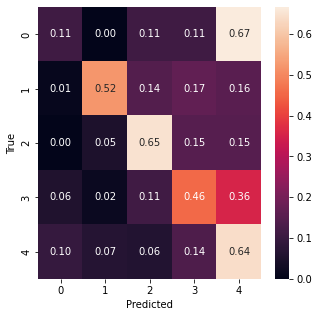

* Epoch 112 / 180


100%|██████████| 158/158 [01:03<00:00,  2.49it/s]


TRAIN - Time: 63.5s - Loss: 1.311732710916785


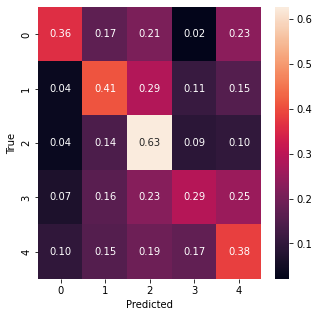

100%|██████████| 28/28 [00:06<00:00,  4.37it/s]


VALIDATION - Time: 6.4s - Loss: 1.2706911734172277


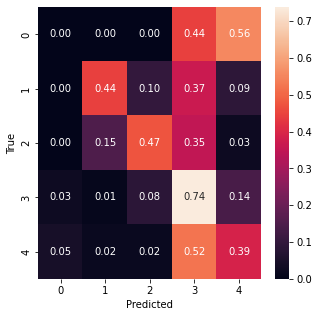

* Epoch 113 / 180


100%|██████████| 158/158 [01:00<00:00,  2.59it/s]


TRAIN - Time: 61.0s - Loss: 1.3209175052522102


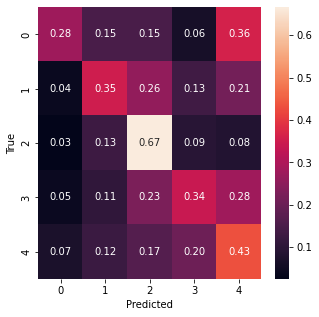

100%|██████████| 28/28 [00:06<00:00,  4.30it/s]


VALIDATION - Time: 6.5s - Loss: 1.325617436851774


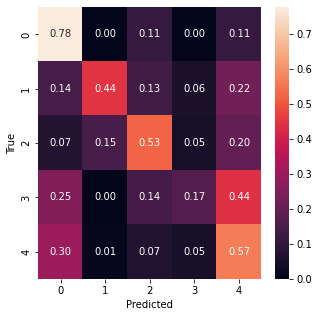

* Epoch 114 / 180


100%|██████████| 158/158 [01:01<00:00,  2.56it/s]


TRAIN - Time: 61.7s - Loss: 1.3343900932541377


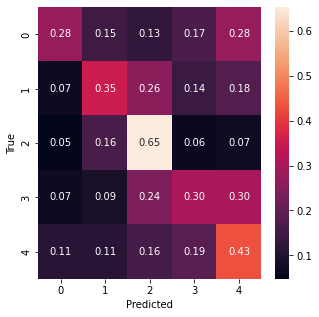

100%|██████████| 28/28 [00:06<00:00,  4.51it/s]


VALIDATION - Time: 6.2s - Loss: 1.1758224410670142


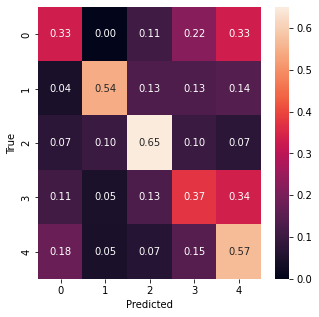

* Epoch 115 / 180


100%|██████████| 158/158 [01:03<00:00,  2.48it/s]


TRAIN - Time: 63.8s - Loss: 1.3388987515546098


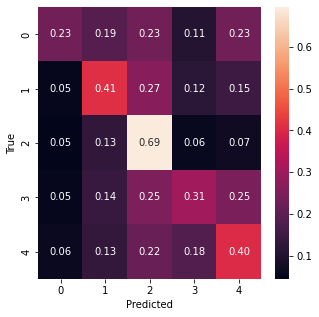

100%|██████████| 28/28 [00:06<00:00,  4.59it/s]


VALIDATION - Time: 6.1s - Loss: 1.2078279938016618


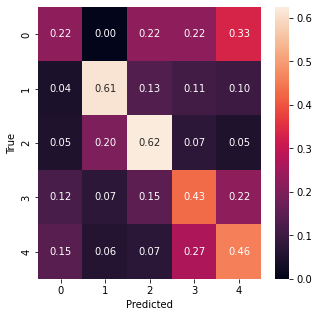

* Epoch 116 / 180


100%|██████████| 158/158 [01:01<00:00,  2.57it/s]


TRAIN - Time: 61.5s - Loss: 1.3136361045173457


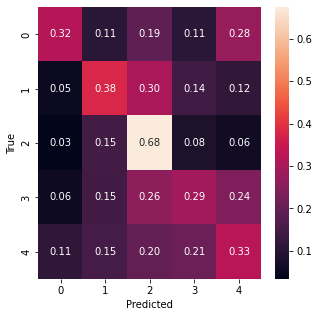

100%|██████████| 28/28 [00:06<00:00,  4.55it/s]


VALIDATION - Time: 6.2s - Loss: 1.2699437886476517


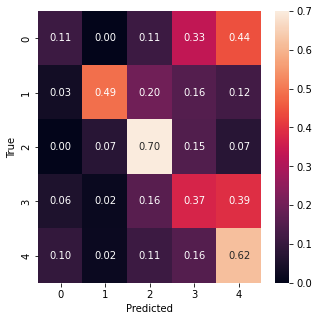

* Epoch 117 / 180


100%|██████████| 158/158 [01:02<00:00,  2.53it/s]


TRAIN - Time: 62.4s - Loss: 1.3284970321987248


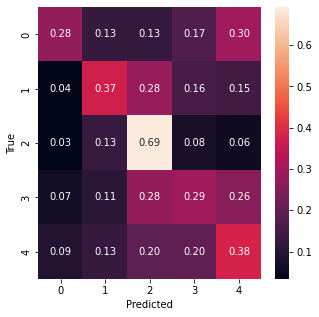

100%|██████████| 28/28 [00:06<00:00,  4.41it/s]


VALIDATION - Time: 6.4s - Loss: 1.215293437242508


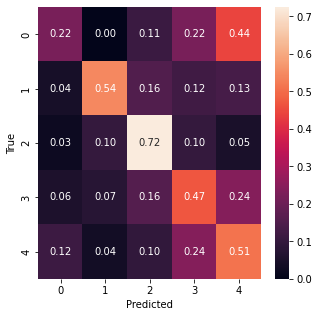

* Epoch 118 / 180


100%|██████████| 158/158 [01:02<00:00,  2.54it/s]


TRAIN - Time: 62.2s - Loss: 1.3385253533532344


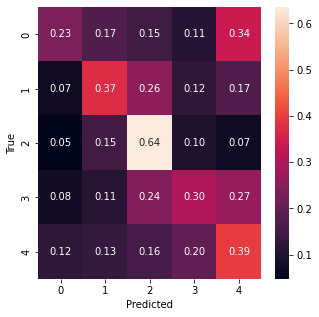

100%|██████████| 28/28 [00:06<00:00,  4.59it/s]


VALIDATION - Time: 6.1s - Loss: 1.2970022175993239


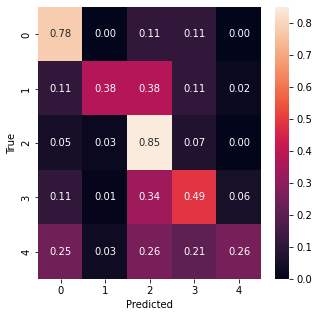

* Epoch 119 / 180


100%|██████████| 158/158 [01:02<00:00,  2.52it/s]


TRAIN - Time: 62.7s - Loss: 1.3343807032591182


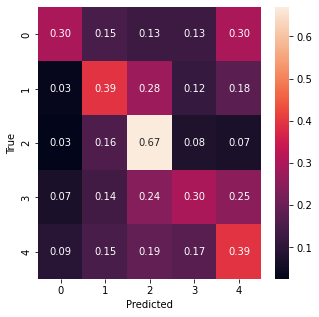

100%|██████████| 28/28 [00:06<00:00,  4.44it/s]


VALIDATION - Time: 6.3s - Loss: 1.1949974851948877


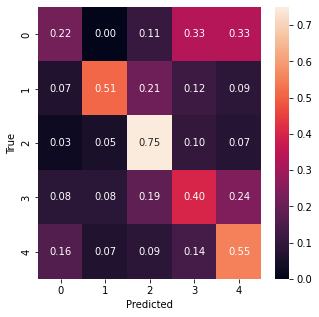

* Epoch 120 / 180


100%|██████████| 158/158 [01:00<00:00,  2.60it/s]


TRAIN - Time: 60.9s - Loss: 1.3609710950640184


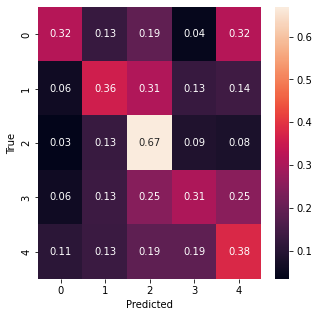

100%|██████████| 28/28 [00:06<00:00,  4.31it/s]


VALIDATION - Time: 6.5s - Loss: 1.2785544246435165


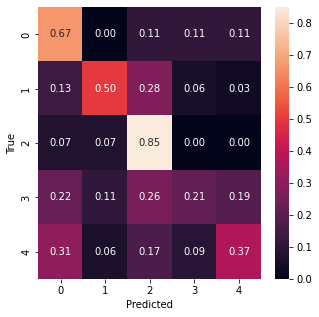

* Epoch 121 / 180


100%|██████████| 158/158 [01:03<00:00,  2.50it/s]


TRAIN - Time: 63.3s - Loss: 1.3339865532102466


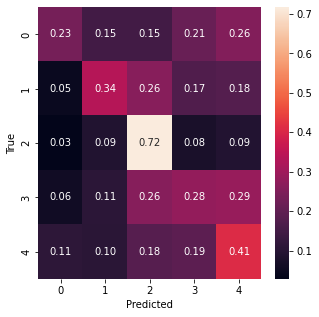

100%|██████████| 28/28 [00:06<00:00,  4.54it/s]


VALIDATION - Time: 6.2s - Loss: 1.3499990190778461


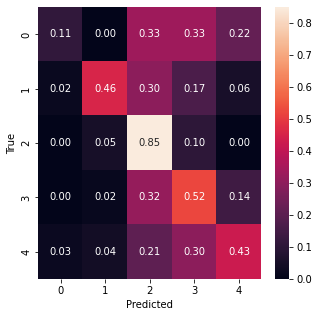

* Epoch 122 / 180


100%|██████████| 158/158 [01:00<00:00,  2.59it/s]


TRAIN - Time: 60.9s - Loss: 1.3445515285564378


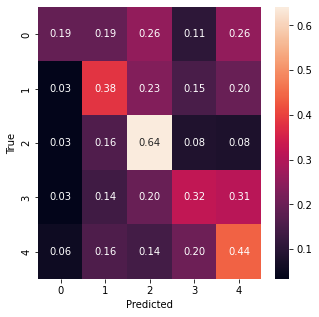

100%|██████████| 28/28 [00:06<00:00,  4.39it/s]


VALIDATION - Time: 6.4s - Loss: 1.184046134352684


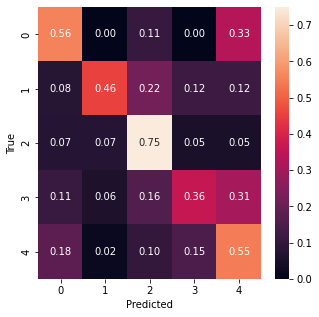

* Epoch 123 / 180


100%|██████████| 158/158 [01:02<00:00,  2.53it/s]


TRAIN - Time: 62.5s - Loss: 1.3184048371224457


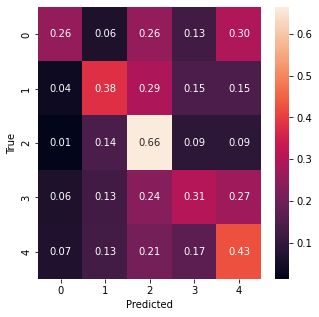

100%|██████████| 28/28 [00:06<00:00,  4.37it/s]


VALIDATION - Time: 6.4s - Loss: 1.303122971739088


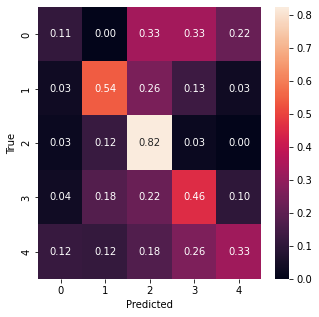

* Epoch 124 / 180


100%|██████████| 158/158 [01:05<00:00,  2.43it/s]


TRAIN - Time: 65.1s - Loss: 1.310507781520674


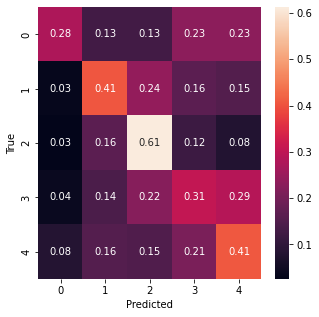

100%|██████████| 28/28 [00:06<00:00,  4.37it/s]


VALIDATION - Time: 6.4s - Loss: 1.195128579224859


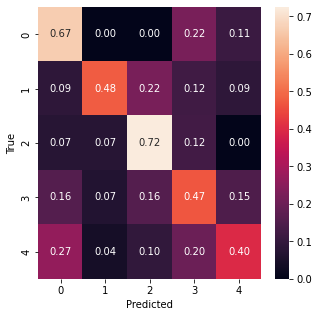

* Epoch 125 / 180


100%|██████████| 158/158 [01:04<00:00,  2.46it/s]


TRAIN - Time: 64.3s - Loss: 1.324199352460572


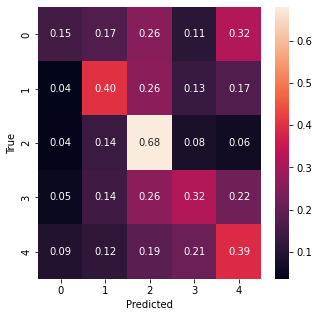

100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


VALIDATION - Time: 6.6s - Loss: 1.2252743818930216


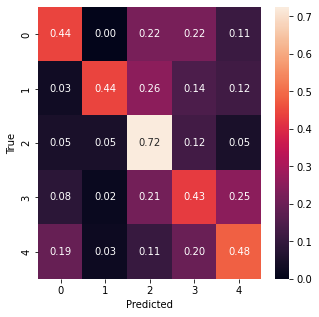

* Epoch 126 / 180


100%|██████████| 158/158 [01:04<00:00,  2.46it/s]


TRAIN - Time: 64.2s - Loss: 1.3236976518661152


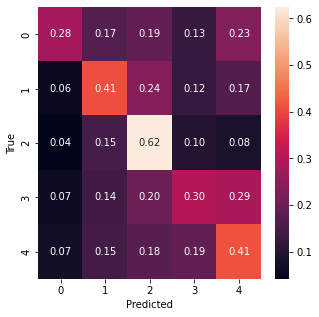

100%|██████████| 28/28 [00:06<00:00,  4.39it/s]


VALIDATION - Time: 6.4s - Loss: 1.3486453167029786


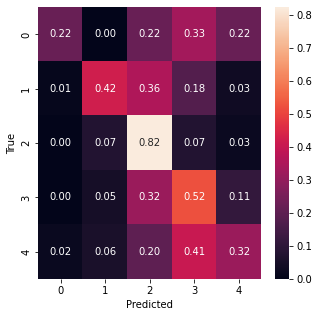

* Epoch 127 / 180


100%|██████████| 158/158 [01:03<00:00,  2.50it/s]


TRAIN - Time: 63.2s - Loss: 1.311774608455127


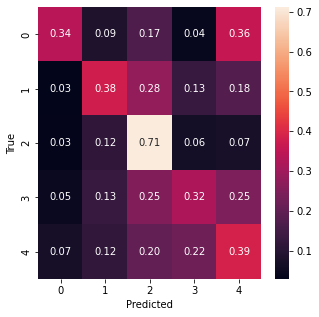

100%|██████████| 28/28 [00:06<00:00,  4.29it/s]


VALIDATION - Time: 6.5s - Loss: 1.2224584072828295


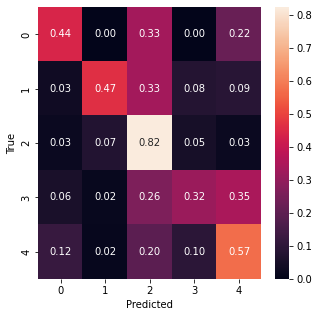

* Epoch 128 / 180


100%|██████████| 158/158 [01:03<00:00,  2.51it/s]


TRAIN - Time: 63.1s - Loss: 1.337414249589171


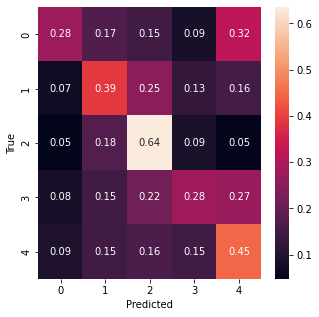

100%|██████████| 28/28 [00:06<00:00,  4.47it/s]


VALIDATION - Time: 6.3s - Loss: 1.195689665419715


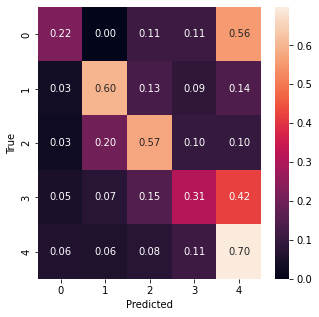

* Epoch 129 / 180


100%|██████████| 158/158 [01:03<00:00,  2.47it/s]


TRAIN - Time: 64.0s - Loss: 1.317064399583429


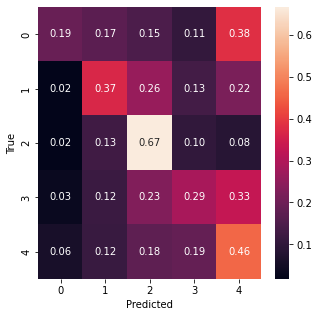

100%|██████████| 28/28 [00:07<00:00,  3.95it/s]


VALIDATION - Time: 7.1s - Loss: 1.1993880846670695


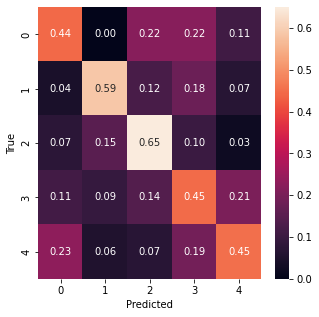

* Epoch 130 / 180


100%|██████████| 158/158 [01:03<00:00,  2.49it/s]


TRAIN - Time: 63.4s - Loss: 1.288287254451196


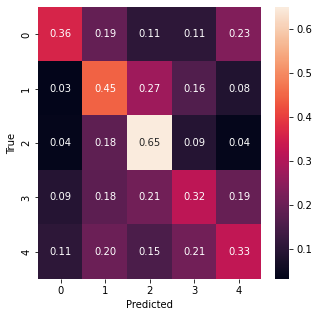

100%|██████████| 28/28 [00:06<00:00,  4.29it/s]


VALIDATION - Time: 6.5s - Loss: 1.2857874355145864


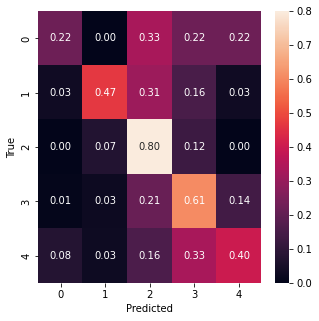

* Epoch 131 / 180


100%|██████████| 158/158 [01:03<00:00,  2.48it/s]


TRAIN - Time: 63.6s - Loss: 1.304002850870543


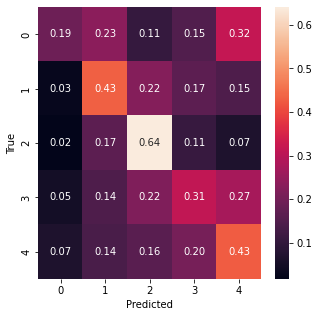

100%|██████████| 28/28 [00:06<00:00,  4.37it/s]


VALIDATION - Time: 6.4s - Loss: 1.2371454366615837


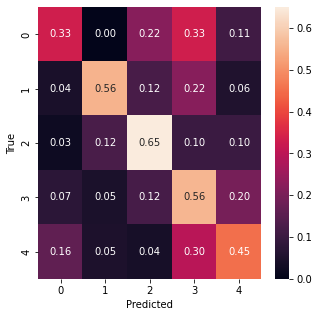

* Epoch 132 / 180


100%|██████████| 158/158 [01:05<00:00,  2.42it/s]


TRAIN - Time: 65.3s - Loss: 1.2772057426126695


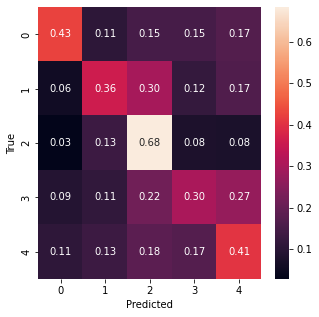

100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


VALIDATION - Time: 6.7s - Loss: 1.1824692956038882


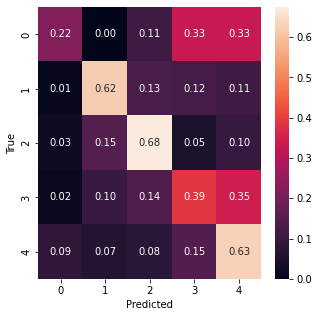

* Epoch 133 / 180


100%|██████████| 158/158 [01:02<00:00,  2.51it/s]


TRAIN - Time: 63.0s - Loss: 1.3090587235704256


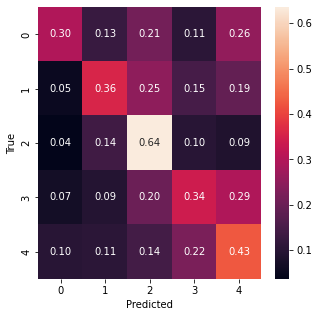

100%|██████████| 28/28 [00:06<00:00,  4.43it/s]


VALIDATION - Time: 6.3s - Loss: 1.2562251218727656


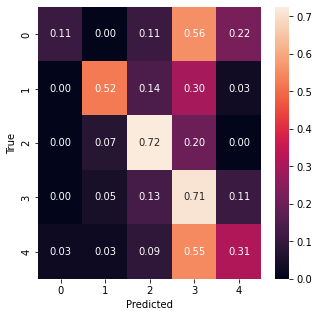

* Epoch 134 / 180


100%|██████████| 158/158 [01:00<00:00,  2.60it/s]


TRAIN - Time: 60.7s - Loss: 1.3272182130360899


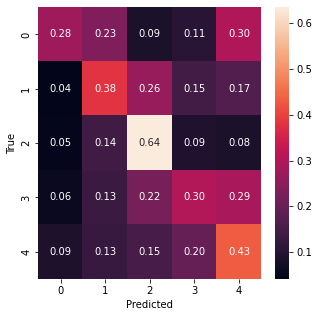

100%|██████████| 28/28 [00:06<00:00,  4.32it/s]


VALIDATION - Time: 6.5s - Loss: 1.1814569192273277


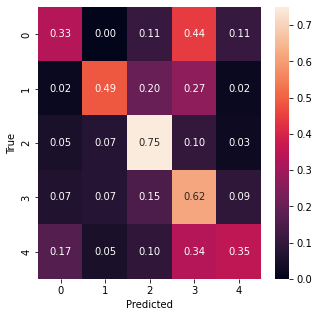

* Epoch 135 / 180


100%|██████████| 158/158 [01:03<00:00,  2.50it/s]


TRAIN - Time: 63.1s - Loss: 1.302072653287574


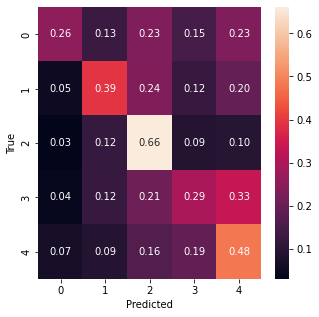

100%|██████████| 28/28 [00:06<00:00,  4.56it/s]


VALIDATION - Time: 6.2s - Loss: 1.1721542860780445


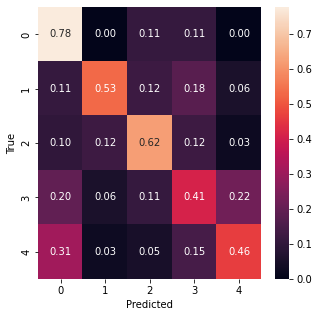

* Epoch 136 / 180


100%|██████████| 158/158 [01:02<00:00,  2.53it/s]


TRAIN - Time: 62.5s - Loss: 1.269109049929848


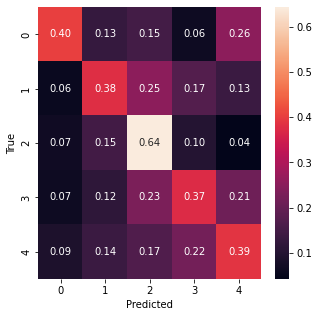

100%|██████████| 28/28 [00:06<00:00,  4.41it/s]


VALIDATION - Time: 6.4s - Loss: 1.1145210223538535


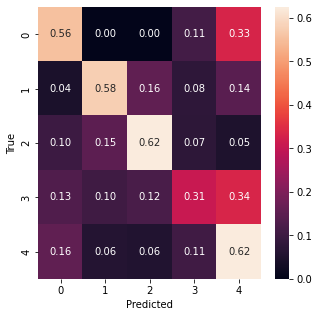

* Epoch 137 / 180


100%|██████████| 158/158 [01:02<00:00,  2.53it/s]


TRAIN - Time: 62.6s - Loss: 1.2916642744329907


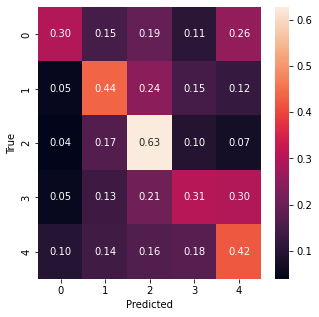

100%|██████████| 28/28 [00:06<00:00,  4.54it/s]


VALIDATION - Time: 6.2s - Loss: 1.3580137597663062


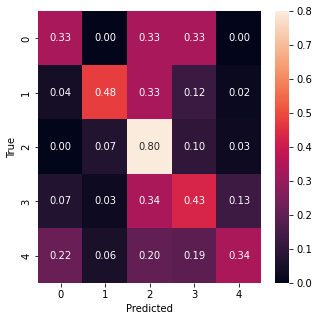

* Epoch 138 / 180


100%|██████████| 158/158 [01:02<00:00,  2.51it/s]


TRAIN - Time: 62.9s - Loss: 1.2769055038313322


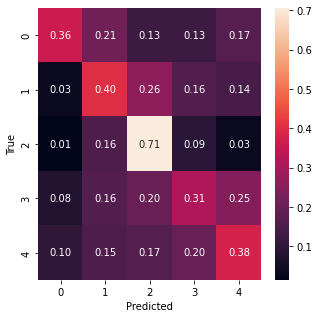

100%|██████████| 28/28 [00:06<00:00,  4.44it/s]


VALIDATION - Time: 6.3s - Loss: 1.306361911552293


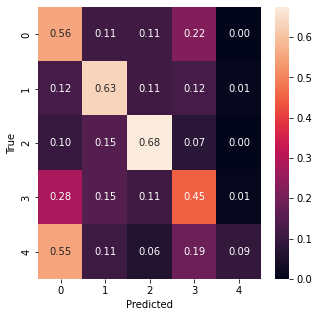

* Epoch 139 / 180


100%|██████████| 158/158 [01:01<00:00,  2.57it/s]


TRAIN - Time: 61.5s - Loss: 1.281949884529356


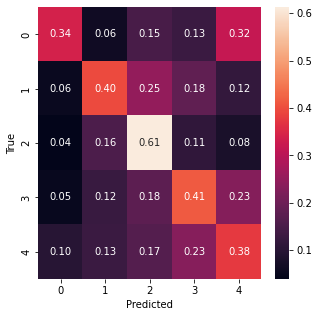

100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


VALIDATION - Time: 6.6s - Loss: 1.3752036754574095


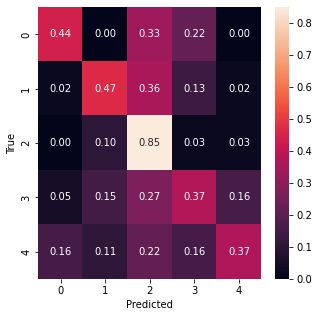

* Epoch 140 / 180


100%|██████████| 158/158 [01:03<00:00,  2.49it/s]


TRAIN - Time: 63.5s - Loss: 1.3061250825471509


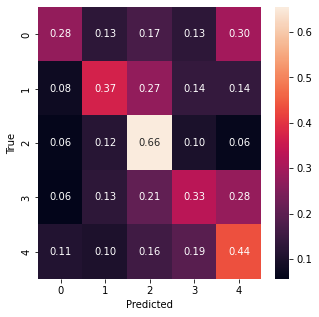

100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


VALIDATION - Time: 6.7s - Loss: 1.1414145742143904


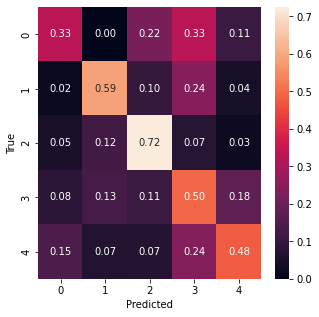

* Epoch 141 / 180


100%|██████████| 158/158 [01:03<00:00,  2.50it/s]


TRAIN - Time: 63.3s - Loss: 1.298440067451212


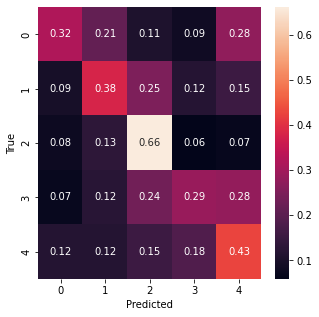

100%|██████████| 28/28 [00:06<00:00,  4.30it/s]


VALIDATION - Time: 6.5s - Loss: 1.2360866133655821


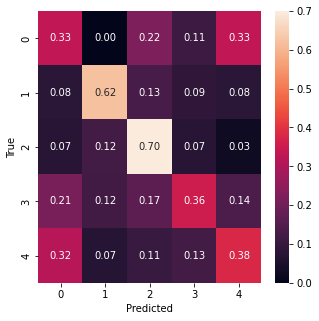

* Epoch 142 / 180


100%|██████████| 158/158 [01:01<00:00,  2.55it/s]


TRAIN - Time: 62.0s - Loss: 1.293015477023547


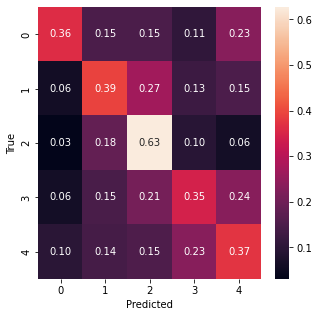

100%|██████████| 28/28 [00:06<00:00,  4.43it/s]


VALIDATION - Time: 6.3s - Loss: 1.156610425029482


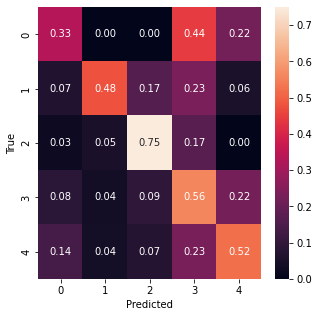

* Epoch 143 / 180


100%|██████████| 158/158 [01:01<00:00,  2.55it/s]


TRAIN - Time: 62.0s - Loss: 1.2920332520822937


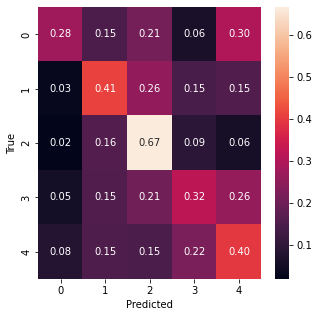

100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


VALIDATION - Time: 7.5s - Loss: 1.175425872206688


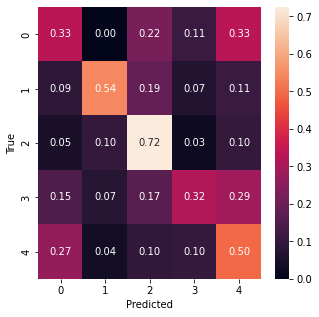

* Epoch 144 / 180


100%|██████████| 158/158 [01:01<00:00,  2.55it/s]


TRAIN - Time: 61.9s - Loss: 1.2667258823219731


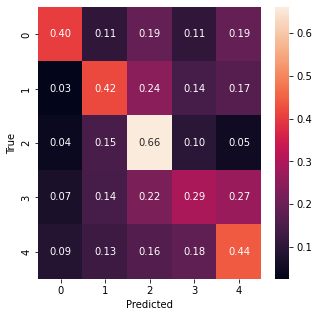

100%|██████████| 28/28 [00:06<00:00,  4.53it/s]


VALIDATION - Time: 6.2s - Loss: 1.204197285430772


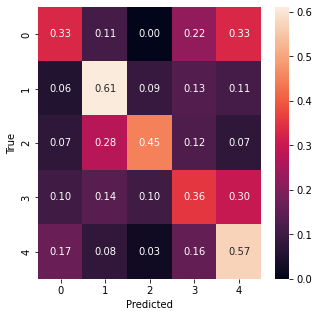

* Epoch 145 / 180


100%|██████████| 158/158 [01:01<00:00,  2.56it/s]


TRAIN - Time: 61.8s - Loss: 1.3009284798857534


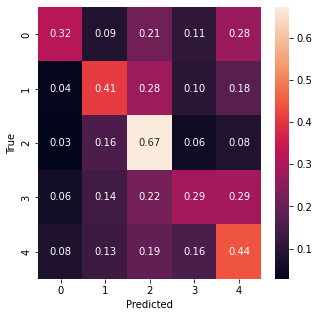

100%|██████████| 28/28 [00:06<00:00,  4.48it/s]


VALIDATION - Time: 6.3s - Loss: 1.1645460511956898


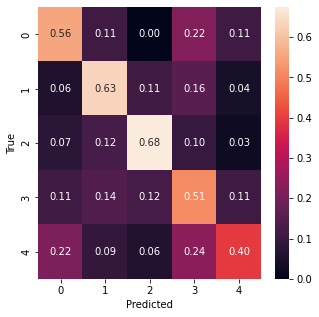

* Epoch 146 / 180


100%|██████████| 158/158 [00:59<00:00,  2.65it/s]


TRAIN - Time: 59.6s - Loss: 1.295022037587587


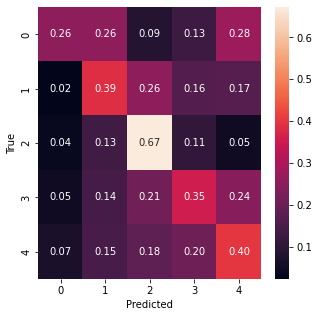

100%|██████████| 28/28 [00:06<00:00,  4.34it/s]


VALIDATION - Time: 6.5s - Loss: 1.185519337654114


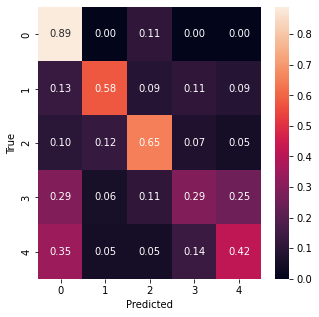

* Epoch 147 / 180


100%|██████████| 158/158 [01:02<00:00,  2.52it/s]


TRAIN - Time: 62.6s - Loss: 1.261005526102042


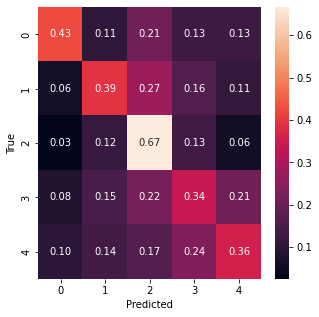

100%|██████████| 28/28 [00:06<00:00,  4.50it/s]


VALIDATION - Time: 6.2s - Loss: 1.2167648673057556


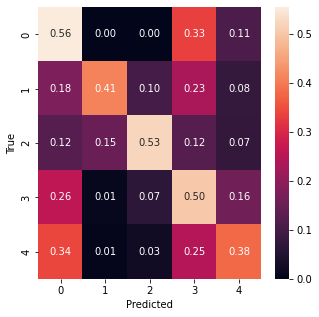

* Epoch 148 / 180


100%|██████████| 158/158 [00:59<00:00,  2.64it/s]


TRAIN - Time: 59.8s - Loss: 1.263140834962266


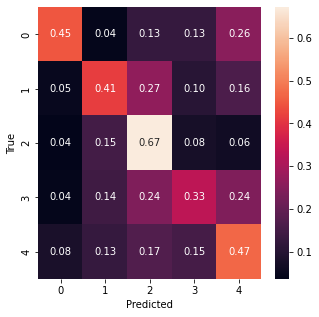

100%|██████████| 28/28 [00:06<00:00,  4.33it/s]


VALIDATION - Time: 6.5s - Loss: 1.2864097250359399


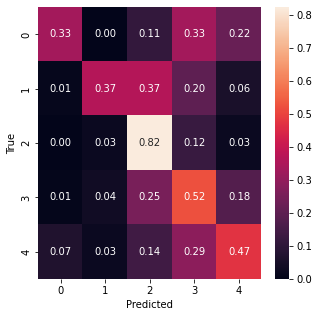

* Epoch 149 / 180


100%|██████████| 158/158 [01:03<00:00,  2.49it/s]


TRAIN - Time: 63.4s - Loss: 1.2959694119193883


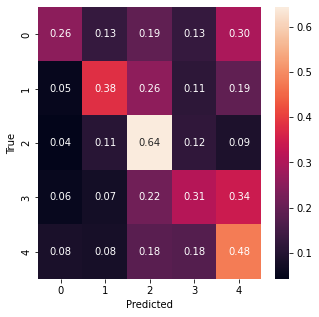

100%|██████████| 28/28 [00:06<00:00,  4.34it/s]


VALIDATION - Time: 6.5s - Loss: 1.2737751262528558


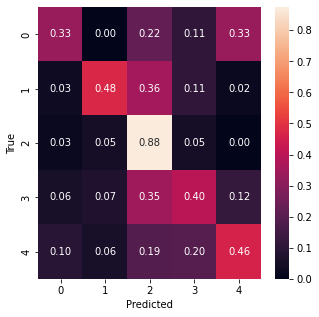

* Epoch 150 / 180


100%|██████████| 158/158 [01:02<00:00,  2.53it/s]


TRAIN - Time: 62.5s - Loss: 1.280064417214333


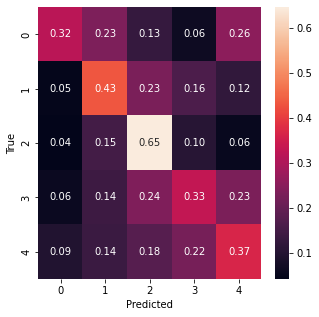

100%|██████████| 28/28 [00:06<00:00,  4.29it/s]


VALIDATION - Time: 6.5s - Loss: 1.269214308687619


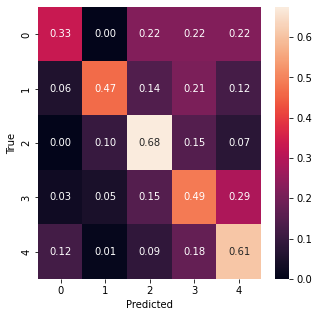

* Epoch 151 / 180


100%|██████████| 158/158 [01:02<00:00,  2.51it/s]


TRAIN - Time: 62.9s - Loss: 1.2602989820739892


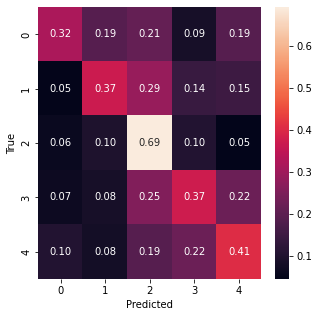

100%|██████████| 28/28 [00:06<00:00,  4.43it/s]


VALIDATION - Time: 6.3s - Loss: 1.195229653801237


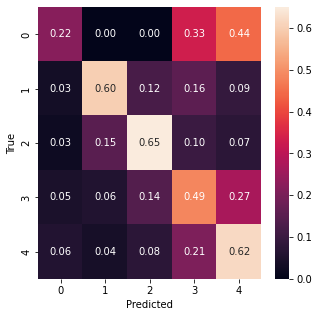

* Epoch 152 / 180


100%|██████████| 158/158 [01:03<00:00,  2.50it/s]


TRAIN - Time: 63.3s - Loss: 1.2561028052734415


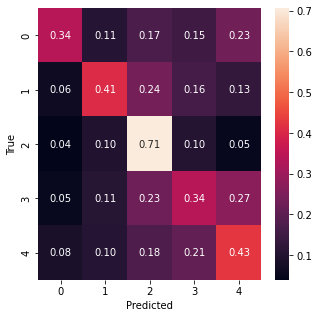

100%|██████████| 28/28 [00:06<00:00,  4.45it/s]


VALIDATION - Time: 6.3s - Loss: 1.2302179123674122


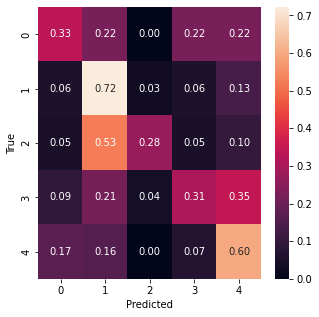

* Epoch 153 / 180


100%|██████████| 158/158 [00:59<00:00,  2.64it/s]


TRAIN - Time: 59.8s - Loss: 1.2710690513441845


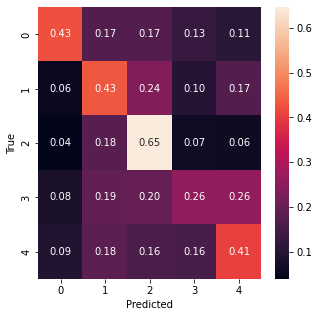

100%|██████████| 28/28 [00:06<00:00,  4.52it/s]


VALIDATION - Time: 6.2s - Loss: 1.2157884112426216


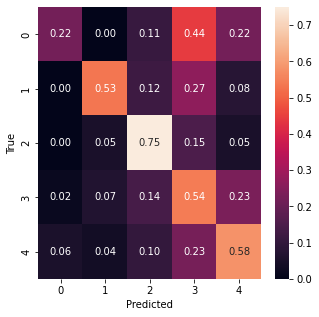

* Epoch 154 / 180


100%|██████████| 158/158 [01:03<00:00,  2.49it/s]


TRAIN - Time: 63.5s - Loss: 1.2602684135678444


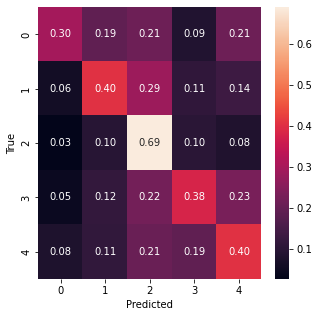

100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


VALIDATION - Time: 6.7s - Loss: 1.217500424810818


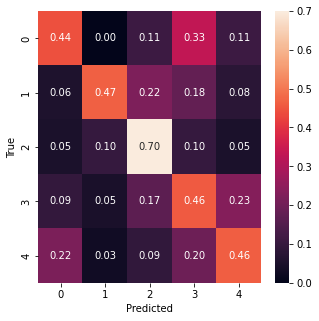

* Epoch 155 / 180


100%|██████████| 158/158 [01:05<00:00,  2.40it/s]


TRAIN - Time: 65.7s - Loss: 1.2958220386806922


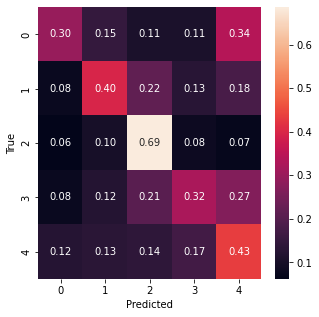

100%|██████████| 28/28 [00:06<00:00,  4.15it/s]


VALIDATION - Time: 6.8s - Loss: 1.2647591531276705


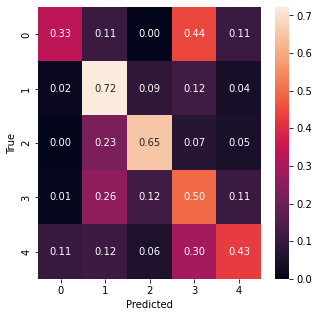

* Epoch 156 / 180


100%|██████████| 158/158 [01:02<00:00,  2.54it/s]


TRAIN - Time: 62.1s - Loss: 1.2657814327674568


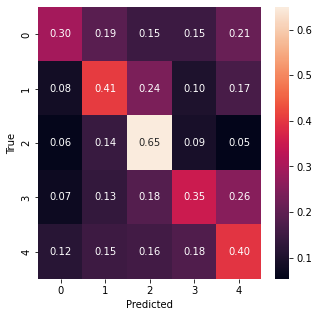

100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


VALIDATION - Time: 6.6s - Loss: 1.270063870719501


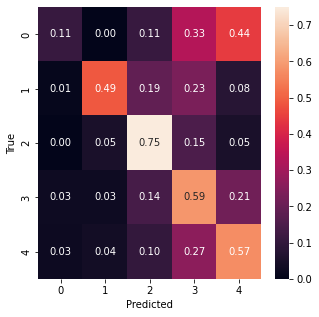

* Epoch 157 / 180


100%|██████████| 158/158 [01:02<00:00,  2.52it/s]


TRAIN - Time: 62.6s - Loss: 1.2650025999998749


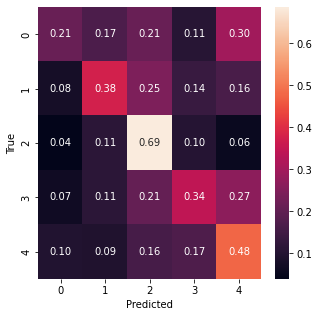

100%|██████████| 28/28 [00:06<00:00,  4.33it/s]


VALIDATION - Time: 6.5s - Loss: 1.2110263385943003


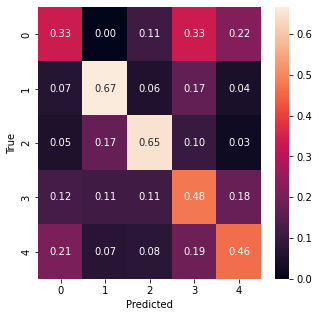

* Epoch 158 / 180


100%|██████████| 158/158 [01:04<00:00,  2.44it/s]


TRAIN - Time: 64.7s - Loss: 1.2842757407623009


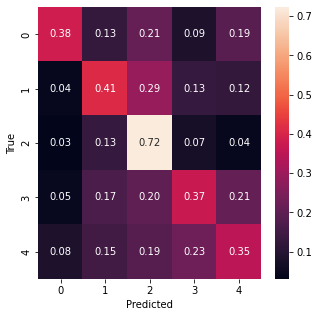

100%|██████████| 28/28 [00:06<00:00,  4.40it/s]


VALIDATION - Time: 6.4s - Loss: 1.2043346124035974


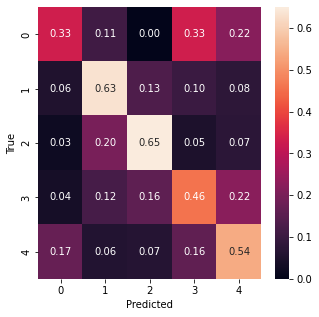

* Epoch 159 / 180


100%|██████████| 158/158 [01:02<00:00,  2.53it/s]


TRAIN - Time: 62.5s - Loss: 1.2460425929932655


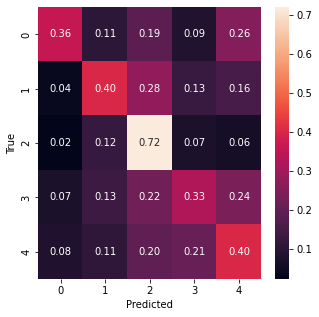

100%|██████████| 28/28 [00:06<00:00,  4.31it/s]


VALIDATION - Time: 6.5s - Loss: 1.3003176684890474


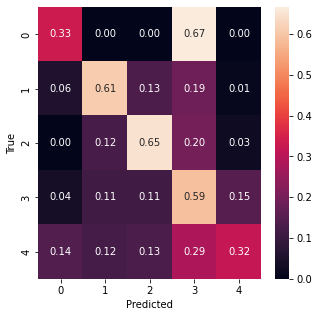

* Epoch 160 / 180


100%|██████████| 158/158 [01:02<00:00,  2.54it/s]


TRAIN - Time: 62.2s - Loss: 1.2475438789476316


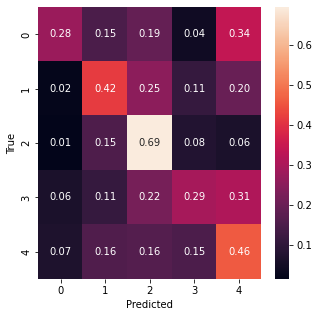

100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


VALIDATION - Time: 6.6s - Loss: 1.2838728449174337


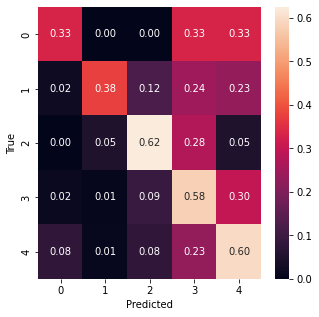

* Epoch 161 / 180


100%|██████████| 158/158 [01:02<00:00,  2.52it/s]


TRAIN - Time: 62.8s - Loss: 1.2544660624823987


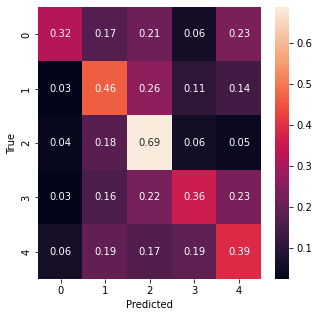

100%|██████████| 28/28 [00:06<00:00,  4.38it/s]


VALIDATION - Time: 6.4s - Loss: 1.199410755719457


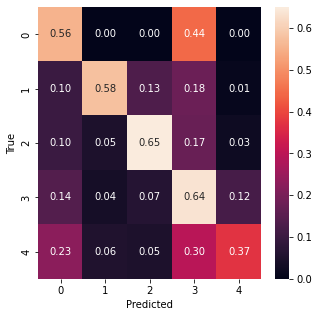

* Epoch 162 / 180


100%|██████████| 158/158 [01:02<00:00,  2.53it/s]


TRAIN - Time: 62.4s - Loss: 1.2920730566676653


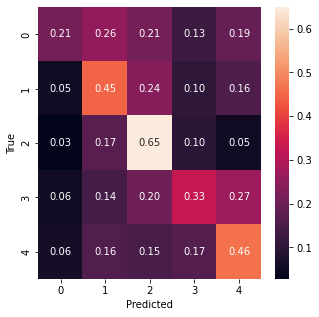

100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


VALIDATION - Time: 6.8s - Loss: 1.2489583449704305


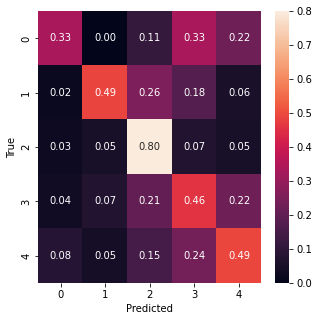

* Epoch 163 / 180


100%|██████████| 158/158 [01:03<00:00,  2.48it/s]


TRAIN - Time: 63.8s - Loss: 1.2766669464262215


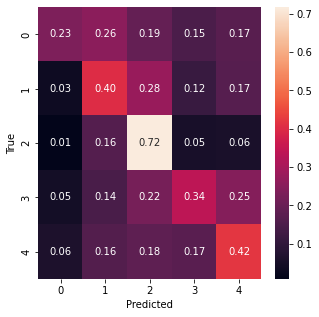

100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


VALIDATION - Time: 6.6s - Loss: 1.4087702993835722


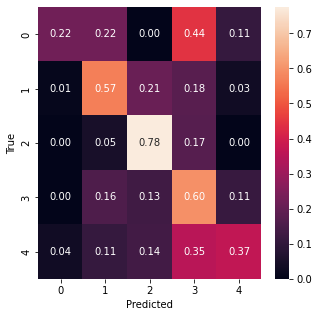

* Epoch 164 / 180


100%|██████████| 158/158 [01:03<00:00,  2.50it/s]


TRAIN - Time: 63.3s - Loss: 1.2282906533042086


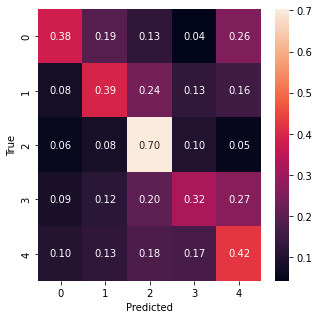

100%|██████████| 28/28 [00:06<00:00,  4.40it/s]


VALIDATION - Time: 6.4s - Loss: 1.2411518096923828


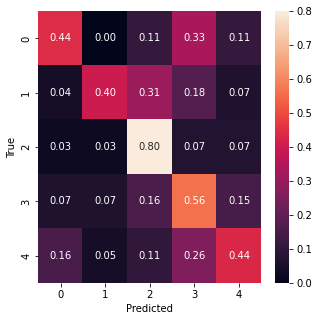

* Epoch 165 / 180


100%|██████████| 158/158 [01:02<00:00,  2.54it/s]


TRAIN - Time: 62.3s - Loss: 1.2372507475599464


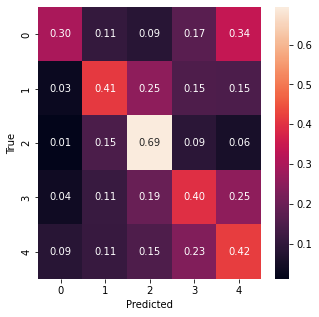

100%|██████████| 28/28 [00:06<00:00,  4.32it/s]


VALIDATION - Time: 6.5s - Loss: 1.2358792147466116


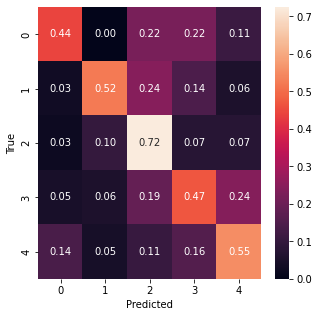

* Epoch 166 / 180


100%|██████████| 158/158 [01:03<00:00,  2.48it/s]


TRAIN - Time: 63.8s - Loss: 1.2348281039467353


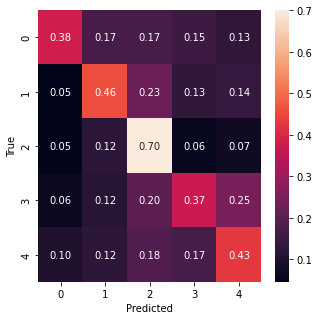

100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


VALIDATION - Time: 6.6s - Loss: 1.3446281531027384


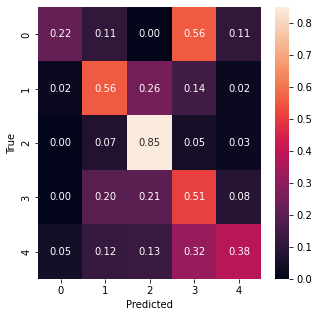

* Epoch 167 / 180


100%|██████████| 158/158 [01:02<00:00,  2.51it/s]


TRAIN - Time: 62.9s - Loss: 1.246362294200101


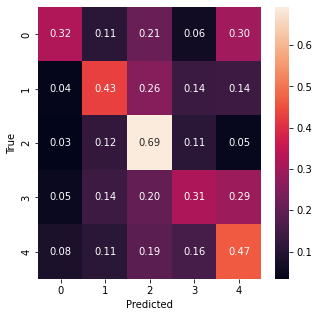

100%|██████████| 28/28 [00:06<00:00,  4.29it/s]


VALIDATION - Time: 6.5s - Loss: 1.2042075821331573


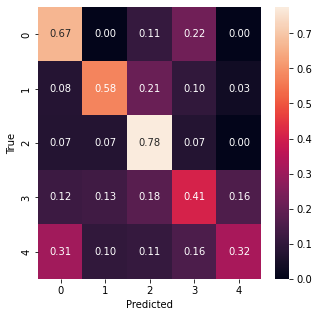

* Epoch 168 / 180


100%|██████████| 158/158 [01:02<00:00,  2.53it/s]


TRAIN - Time: 62.6s - Loss: 1.2486108994182152


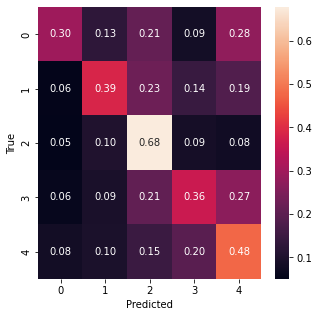

100%|██████████| 28/28 [00:06<00:00,  4.46it/s]


VALIDATION - Time: 6.3s - Loss: 1.2241499466555459


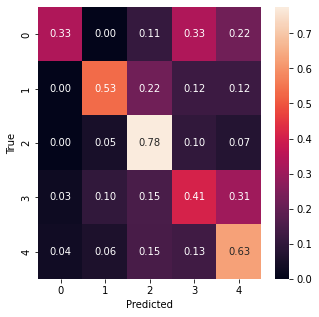

* Epoch 169 / 180


100%|██████████| 158/158 [01:05<00:00,  2.40it/s]


TRAIN - Time: 66.0s - Loss: 1.283000807596159


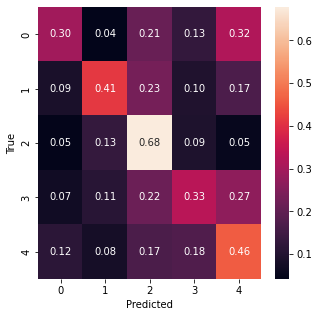

100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


VALIDATION - Time: 7.2s - Loss: 1.234373356614794


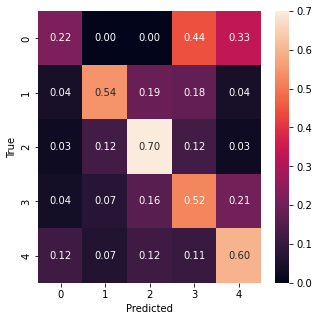

* Epoch 170 / 180


100%|██████████| 158/158 [01:03<00:00,  2.49it/s]


TRAIN - Time: 63.5s - Loss: 1.2295322652104537


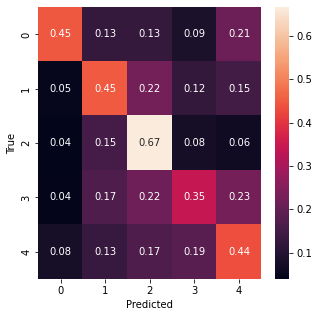

100%|██████████| 28/28 [00:06<00:00,  4.27it/s]


VALIDATION - Time: 6.6s - Loss: 1.2801107977117807


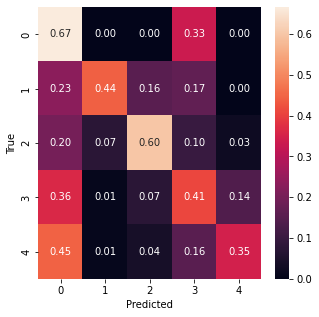

* Epoch 171 / 180


100%|██████████| 158/158 [01:02<00:00,  2.53it/s]


TRAIN - Time: 62.4s - Loss: 1.2031290783912314


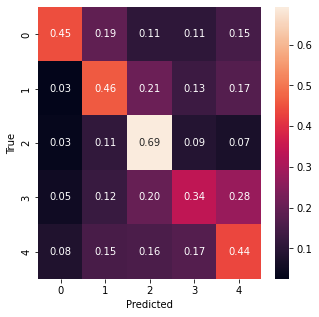

100%|██████████| 28/28 [00:06<00:00,  4.30it/s]


VALIDATION - Time: 6.5s - Loss: 1.1696831711700983


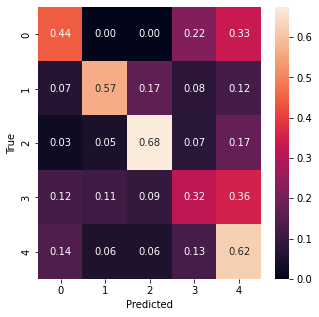

* Epoch 172 / 180


100%|██████████| 158/158 [01:07<00:00,  2.34it/s]


TRAIN - Time: 67.5s - Loss: 1.231363044509405


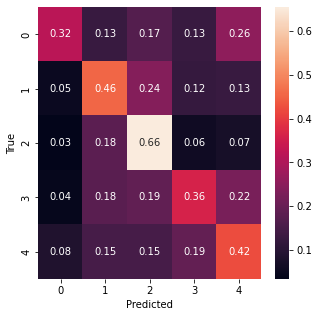

100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


VALIDATION - Time: 6.6s - Loss: 1.178587455834661


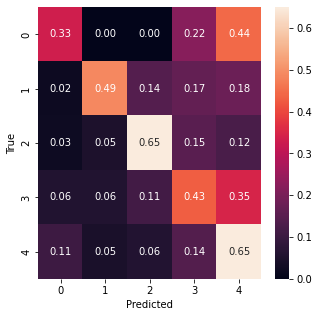

* Epoch 173 / 180


100%|██████████| 158/158 [01:06<00:00,  2.39it/s]


TRAIN - Time: 66.1s - Loss: 1.2259680425064474


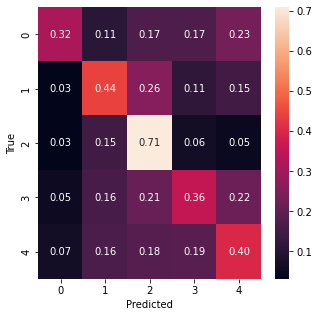

100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


VALIDATION - Time: 7.0s - Loss: 1.1520736430372511


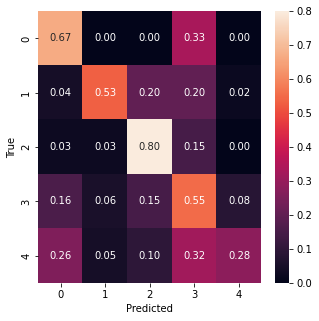

* Epoch 174 / 180


100%|██████████| 158/158 [01:04<00:00,  2.46it/s]


TRAIN - Time: 64.3s - Loss: 1.2742961735665044


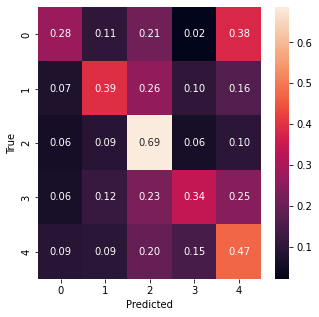

100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


VALIDATION - Time: 7.8s - Loss: 1.3509785320077625


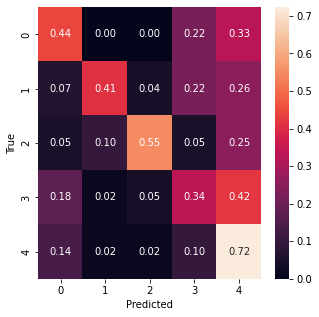

* Epoch 175 / 180


100%|██████████| 158/158 [01:03<00:00,  2.50it/s]


TRAIN - Time: 63.2s - Loss: 1.250247620329072


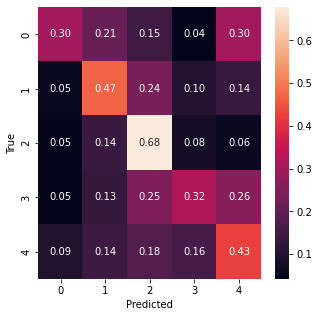

100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


VALIDATION - Time: 6.6s - Loss: 1.176747394459588


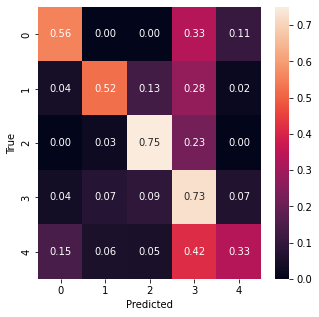

* Epoch 176 / 180


100%|██████████| 158/158 [01:04<00:00,  2.47it/s]


TRAIN - Time: 64.1s - Loss: 1.2255182105906397


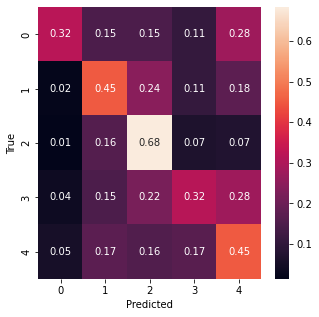

100%|██████████| 28/28 [00:07<00:00,  3.83it/s]


VALIDATION - Time: 7.3s - Loss: 1.179957553744316


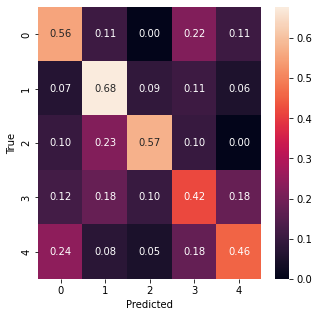

* Epoch 177 / 180


100%|██████████| 158/158 [01:10<00:00,  2.24it/s]


TRAIN - Time: 70.6s - Loss: 1.2015753263914133


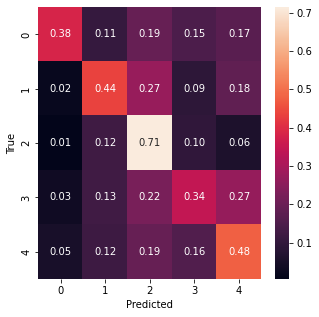

100%|██████████| 28/28 [00:07<00:00,  3.76it/s]


VALIDATION - Time: 7.5s - Loss: 1.29186159159456


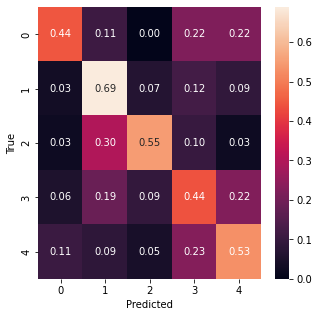

* Epoch 178 / 180


100%|██████████| 158/158 [01:08<00:00,  2.31it/s]


TRAIN - Time: 68.3s - Loss: 1.2289480152009407


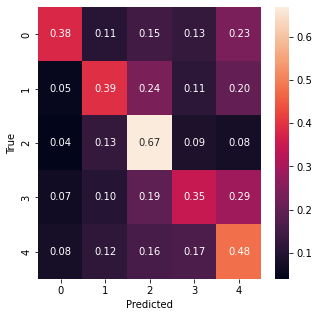

100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


VALIDATION - Time: 7.0s - Loss: 1.249749488064221


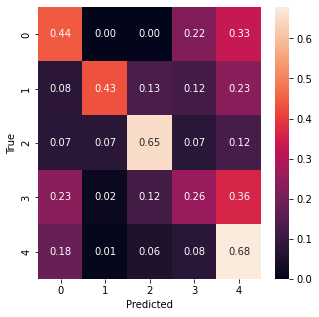

* Epoch 179 / 180


100%|██████████| 158/158 [01:07<00:00,  2.35it/s]


TRAIN - Time: 67.1s - Loss: 1.2322833847395982


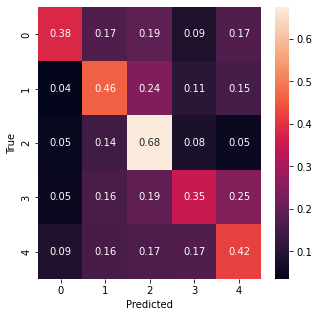

100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


VALIDATION - Time: 7.2s - Loss: 1.17265060544014


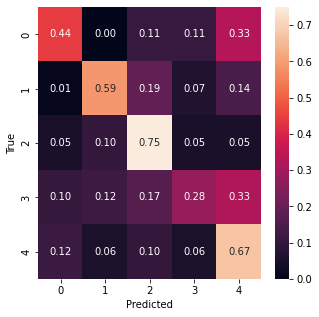

* Epoch 180 / 180


100%|██████████| 158/158 [01:09<00:00,  2.28it/s]


TRAIN - Time: 69.2s - Loss: 1.2095341384410858


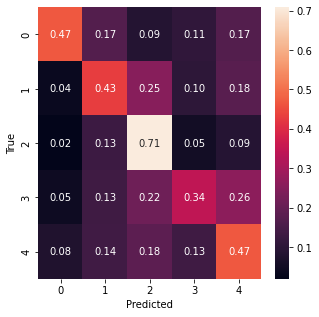

100%|██████████| 28/28 [00:07<00:00,  3.95it/s]


VALIDATION - Time: 7.1s - Loss: 1.201025143265724


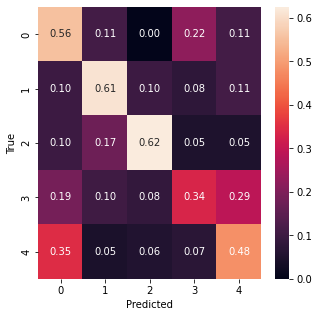

In [ ]:
################## DATA LOADING AND MODEL ##################

# Data albumentations
aug_1 = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(0.1),
    A.Rotate(180),
]

aug_2 = [
    A.Resize(img_size + img_size//20, img_size + img_size//20),
    A.RandomCrop(img_size, img_size),
    ToTensorV2()
]

train_transforms = A.Compose(aug_1 + aug_2)
transforms = A.Compose(aug_2)

# Data Splitting

print ("Loading dataset\n")
 
detection_dataset = pd.read_csv('/content/drive/Shareddrives/Projeto DACO/single label dataset/dataset_labels.csv')

label_encoder_1 = preprocessing.LabelEncoder()
detection_dataset ['presence'] = label_encoder_1.fit_transform(detection_dataset ['presence'])

label_encoder_2 = preprocessing.LabelEncoder()
detection_dataset ['type'] = label_encoder_2.fit_transform(detection_dataset ['type'])

# Labels map
print("Detection's Label Map")
print("Class 0 - ", label_encoder_1.inverse_transform([0]))
print("Class 1 - ", label_encoder_1.inverse_transform([1]))

print("\nClassification's Label Map")
print("Class 0 - ", label_encoder_2.inverse_transform([0]))
print("Class 1 - ", label_encoder_2.inverse_transform([1]))
print("Class 2 - ", label_encoder_2.inverse_transform([2]))
print("Class 3 - ", label_encoder_2.inverse_transform([3]))
print("Class 4 - ", label_encoder_2.inverse_transform([4]))
print("Class 5 - ", label_encoder_2.inverse_transform([5]))

d_train_set, d_val_set = train_test_split(detection_dataset, test_size=0.3, random_state=123)
d_val_set, d_test_set = train_test_split(d_val_set, test_size=0.5, random_state=123)


# The classification dataset corresponds to the detection dataset with hemorrhage presence
classification_dataset = detection_dataset[detection_dataset['presence']==0]

# Computed before eliminating the images for the test dataset
class_weights = class_weight.compute_class_weight(
              class_weight='balanced',
              classes=[0, 1, 2, 3, 4], # the label 5 is not included since the classification_dataset DOES NOT HAVE images from class 5 (because of the previous code line)
              y=classification_dataset['type'])

class_weights = torch.tensor(class_weights,dtype=torch.float).cuda()

c_test_set = d_test_set[d_test_set['presence']==0] # This ensures that the images with ICH used in the d_test_set are the same used in c_test_set

# The following two lines ensure that the images used to split the dataset into training and validation DO NOT include the c_test_set ones
cond = c_test_set['ID'].isin(classification_dataset['ID'])
classification_dataset.drop(c_test_set['ID'].index, inplace = True)

c_train_set, c_val_set = train_test_split(classification_dataset, test_size=0.15, random_state=123)

c_train_set, c_val_set = c_train_set.reset_index(drop=True), c_val_set.reset_index(drop=True)

c_train_set = small_dataset(c_train_set, dataset_fold, train_transforms)
c_val_set = small_dataset(c_val_set, dataset_fold, transforms)

tr = DataLoader(c_train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val = DataLoader(c_val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print ("\nLoaded \n")

# Model

if (model_selected == 'VGG'):
  model = VGG16()
elif (model_selected == 'ResNeXt'):
  ResNeXt = models.resnext101_32x8d(pretrained=False, num_classes=6)
  model = ResNeXt()

opt = optim.Adam(model.parameters(), lr = LEARNING_RATE)

loss_fc = nn.CrossEntropyLoss(weight=class_weights)

################## TRAINING ##################

print("\nTraining")

train_history = []
val_history = []
best_val_loss = np.inf

epoch_values = []

for epoch in range(EPOCHS):
      print(f'* Epoch {epoch+1} / {EPOCHS}')
      
      train_loss, tr_true_pred, tr_final_pred = epoch_iterations (tr, model, loss_fc, device, 'TRAIN', opt, True)
      evaluation_metrics(tr_true_pred, tr_final_pred)
      
      val_loss, val_true_pred, val_final_pred = epoch_iterations (val, model, loss_fc, device, 'VALIDATION', None,  False)
      evaluation_metrics(val_true_pred, val_final_pred)

      if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_selected + '_classification_best_model.pth')

      # save latest model
      torch.save(model.state_dict(), model_selected + '_classification_latest_model.pth')

      # save training history for plotting purposes
      train_history.append(train_loss)
      val_history.append(val_loss)
      epoch_values.append(epoch+1)
  


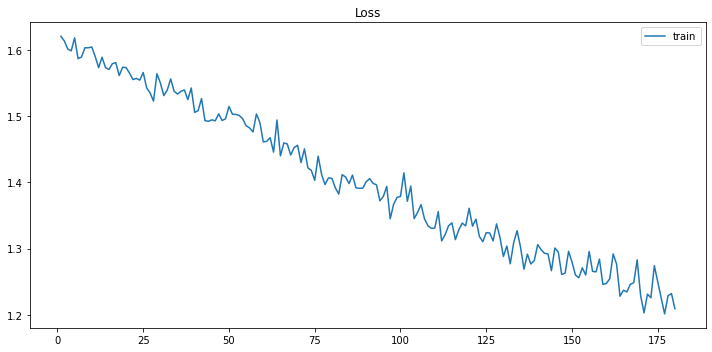

In [ ]:
loss_plot2 (epoch_values, train_history)

In [ ]:
# Save info as CVS file

info= pd.DataFrame({"epoch": epoch_values, "training loss": train_history, "validation loss": val_history})
info.to_csv('/content/drive/Shareddrives/Projeto DACO/loss_180epochs.csv', index=False, header=True)